# Imports

In [1]:
import sys
from pathlib import Path
import pandas as pd
from datetime import datetime, timedelta
import logging

# COMPREHENSIVE LOGGING SUPPRESSION - Set this BEFORE any imports
logging.disable(logging.INFO)  # This disables all INFO and below messages

# Add the project root to Python path
project_root = Path.cwd().parent  # Adjust this path to your project root
sys.path.insert(0, str(project_root))

from src.data.storage.database import get_db_manager
from src.dashboard.services.symbol_service import SymbolService
from src.dashboard.services.market_data_service import MarketDataService

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.ticker import FixedLocator, FixedFormatter
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import seaborn as sns
from typing import Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

print("All imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {'GPU' if torch.cuda.is_available() else 'CPU'}")

from scipy import stats
import math

All imports successful!
PyTorch version: 2.7.0+cu128
Device: GPU


# Load Data

In [2]:
import pandas as pd
import sys
from pathlib import Path

# Add project to path
project_root = Path.cwd()
sys.path.insert(0, str(project_root))

from src.data.storage.database import get_db_manager

def get_all_stocks_simple():
  """
  Simple function using direct database calls.
  """
  try:
      db = get_db_manager()

      # Get all symbols
      symbols = db.get_symbols_with_data()
      print(f"Found {len(symbols)} symbols")

      # Get stock info
      stock_info_list = []
      for symbol in symbols:
          info = db.get_stock_info(symbol)
          if info:
              stock_info_list.append(info)

      stock_info_df = pd.DataFrame(stock_info_list)

      # Get market data for all symbols (last 30 days)
      from datetime import datetime, timedelta
      end_date = datetime.now()
      start_date = end_date - timedelta(days=30)

      all_data = []
      for symbol in symbols:
          try:
              df = db.get_market_data(symbol, start_date, end_date)
              if not df.empty:
                  all_data.append(df)
          except:
              continue

      stock_data_df = pd.concat(all_data, ignore_index=True) if all_data else pd.DataFrame()

      return stock_data_df, stock_info_df, symbols

  except Exception as e:
      print(f"Error: {e}")
      return pd.DataFrame(), pd.DataFrame(), []


In [3]:
# Run it
stock_data_df, stock_info_df, symbols = get_all_stocks_simple()

Found 1057 symbols


In [4]:
# Check what dates we actually got
if not stock_data_df.empty:
  print("Date range in retrieved data:")
  print(f"Min: {stock_data_df['timestamp'].min()}")
  print(f"Max: {stock_data_df['timestamp'].max()}")
  print(f"Sample timestamps:")
  print(stock_data_df['timestamp'].head())



Date range in retrieved data:
Min: 2025-07-18 08:30:00
Max: 2025-08-15 14:30:00
Sample timestamps:
0   2025-07-18 08:30:00
1   2025-07-18 09:30:00
2   2025-07-18 10:30:00
3   2025-07-18 11:30:00
4   2025-07-18 12:30:00
Name: timestamp, dtype: datetime64[ns]


In [5]:
# Display results
print("\n" + "="*50)
print("STOCK DATA SUMMARY:")
print("="*50)
if not stock_data_df.empty:
    print(f"Market data shape: {stock_data_df.shape}")
    print(f"Date range: {stock_data_df['timestamp'].min()} to {stock_data_df['timestamp'].max()}")
    print(f"Symbols in data: {stock_data_df['symbol'].nunique()}")
    #print("\nSample market data:")
    #print(stock_data_df.head())
else:
    print("No market data available")

print("\n" + "="*50)
print("STOCK INFO SUMMARY:")
print("="*50)
if not stock_info_df.empty:
    print(f"Stock info shape: {stock_info_df.shape}")
    print(f"Available sectors: {stock_info_df['sector'].nunique()}")
    print(f"Available industries: {stock_info_df['industry'].nunique()}")
    #print("\nSample stock info:")
    #print(stock_info_df.head())
else:
    print("No stock info available")

print(f"\nTotal symbols found: {len(symbols)}")


STOCK DATA SUMMARY:
Market data shape: (154473, 8)
Date range: 2025-07-18 08:30:00 to 2025-08-15 14:30:00
Symbols in data: 1052

STOCK INFO SUMMARY:
Stock info shape: (1057, 12)
Available sectors: 11
Available industries: 131

Total symbols found: 1057


# Analysis

In [6]:
# Visualization basics
%matplotlib inline

fig_path = r'D:\PythonProjects\MLTrading\notebooks\fig'  


def pred_color_presentation(c):
    custom_palette_presentation = {
        'midnight-blue': '#191970',
        'forest-green': '#228B22',
        'muted-gold': '#B8860B',
        'light-gray': '#D3D3D3',
        'sea-green': '#2E8B57',
        'teal-green': '#008080',
        'highlight': '#C19A6B',
        'black': '#000000',
        'color1':'#dfdfdf',
        'color2':'#dfb834',
        'color3':'#f1f6db',
        'color4':'#649e92',
        'color5':'#a13d61',
    }
    return custom_palette_presentation.get(c, "Invalid color name")

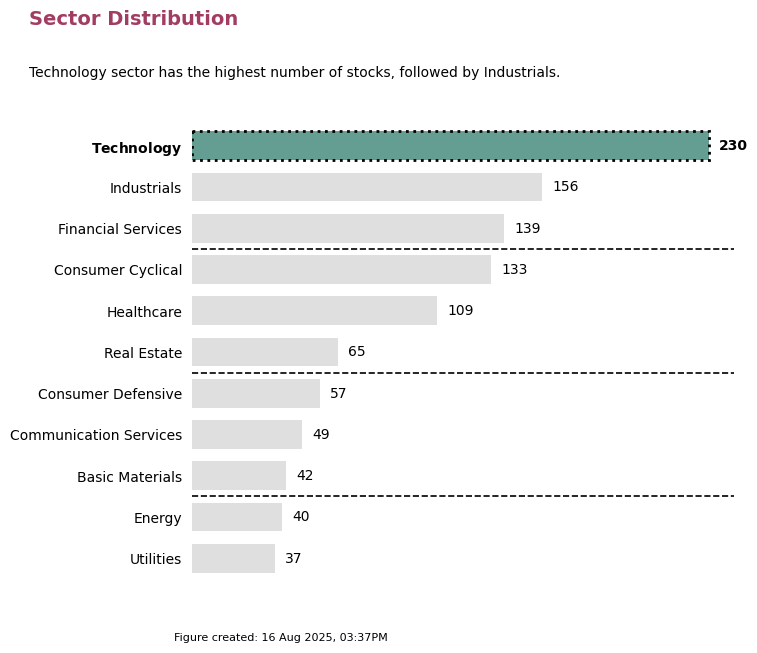

In [7]:
import datetime
# Get current date and time
now = datetime.datetime.now()
formatted_date_time = now.strftime("%d %b %Y, %I:%M%p") 

# Prepare unique sector counts
temp_df = stock_info_df[['symbol', 'sector']].drop_duplicates()
sector_counts = temp_df['sector'].value_counts().sort_values(ascending=False)

# Identify the sector with the highest count
max_index = sector_counts.idxmax()

# Define colors based on the highest count
colors = [pred_color_presentation('color1') if sector != max_index else pred_color_presentation('color4') for sector in sector_counts.index]

# Create a horizontal bar chart with highest at the top
ax = sector_counts.plot(kind='barh', figsize=(7, 6), width=0.7, color=colors)

# Reverse the order so the highest value appears at the top
ax.invert_yaxis()

# Keep y-labels but remove y-ticks
ax.set_yticks(range(len(sector_counts)))

# Make y-labels and bold the one for max industry
yticklabels = []
for sector in sector_counts.index:
    if sector == max_index:
        yticklabels.append(f"$\\bf{{{sector}}}$")
    else:
        yticklabels.append(sector)
ax.set_yticklabels(yticklabels, fontsize=10)

ax.tick_params(left=False)

# Add margin space between labels and bars
ax.margins(y=0.1)

# Add horizontal lines to group pairs of three
for i in range(3, len(sector_counts), 3):
    ax.axhline(y=i - 0.5, color='black', linestyle='dashed', linewidth=1.2)

# Customize the chart
ax.set_xlabel('Number of Stocks')
ax.set_ylabel('')
ax.set_xticklabels([])  
ax.xaxis.set_visible(False)  
ax.grid(axis='x', linestyle='none')
ax.grid(axis='y', linestyle='none')

# Remove unnecessary spines
for spine in ['right', 'top', 'bottom', 'left']:
    ax.spines[spine].set_visible(False)

# Get bar positions for count labels
bar_containers = ax.containers  
bar_y_positions = [rect.get_y() + rect.get_height() / 2 for rect in bar_containers[0]]

# Add count labels with bold for the highest count
for count, y_pos, sector in zip(sector_counts, bar_y_positions, sector_counts.index):
    fontweight = 'bold' if sector == max_index else 'normal'
    ax.text(
        count + max(sector_counts) * 0.02,
        y_pos,
        str(count),
        va='center',
        ha='left',
        fontsize=10,
        fontweight=fontweight
    )

# Add a dotted border around the bar with the highest count
for rect, sector in zip(bar_containers[0], sector_counts.index):
    if sector == max_index:
        x = rect.get_x()
        y = rect.get_y()
        width = rect.get_width()
        height = rect.get_height()

        dotted_rect = patches.Rectangle(
            (x, y),
            width,
            height,
            linewidth=2,
            edgecolor='black',
            facecolor='none',
            linestyle='dotted'
        )
        ax.add_patch(dotted_rect)
        break

# Add annotation for the highest industry
plt.annotate(
    'Sector Distribution', 
    xy=(-0.3, 1.2), 
    xycoords='axes fraction', 
    fontsize=14, 
    fontweight='bold',
    ha='left', 
    va='bottom',
    color=pred_color_presentation('color5')
)

plt.annotate(
    f'{sector_counts.index[0]} sector has the highest number of stocks, followed by {sector_counts.index[1]}.', 
    xy=(-0.3, 1.09), 
    xycoords='axes fraction', 
    fontsize=10, 
    ha='left', 
    va='bottom',
    color='black'
)

# Add footnote with date and time
plt.figtext(
    0.1,  
    0.01,  
    f"Figure created: {formatted_date_time}",
    horizontalalignment='left',
    verticalalignment='bottom',
    fontsize=8,
    color='black'
)

# Save and show the plot
fig_name = f'sector_distribution.jpg'
plt.savefig(os.path.join(fig_path, fig_name), bbox_inches='tight')
plt.show()

In [8]:
selected_sector = 'Technology'
selected_sector_symbols = stock_info_df['symbol'][stock_info_df['sector'] == selected_sector]
#selected_sector_symbols =['AEE', 'AEP', 'AES', 'ATO']
#selected_sector_symbols =['AEE', 'AEP']
ohlc_df = stock_data_df[stock_data_df['symbol'].isin(selected_sector_symbols)]
ohlc_df = ohlc_df.drop(columns=['source'])

# Explore the Data

In [9]:
print("Basic statistics by symbol:")
print(ohlc_df.groupby('symbol')[['open', 'high', 'low', 'close', 'volume']].describe())

Basic statistics by symbol:
         open                                                                \
        count        mean        std       min       25%      50%       75%   
symbol                                                                        
AAPL    147.0  216.658382   9.341553  201.9801  210.8000  214.145  227.1300   
ACIW    147.0   44.458869   1.730991   40.7200   43.4650   44.875   45.5300   
ACLS    147.0   75.643520   4.463903   66.5750   72.9800   74.780   79.3425   
ACN     147.0  262.598422  18.121378  237.1800  245.2925  258.355  281.4725   
ADBE    147.0  355.578148  13.980030  333.1300  341.4100  355.950  370.3575   
...       ...         ...        ...       ...       ...      ...       ...   
XRX     147.0    4.829539   0.833978    3.9450    4.1550    4.265    5.5325   
YOU     147.0   31.102151   1.540438   28.7050   29.8300   30.360   32.3225   
ZBRA    147.0  327.725369  11.144775  301.9900  319.4325  331.365  334.9450   
ZM      147.0   73.27358

In [10]:
selected_sector_symbols_9 = selected_sector_symbols[:9]

In [11]:
num_symbols = len(selected_sector_symbols_9)
# Determine grid size (e.g., 3 columns)
cols = 3
rows = math.ceil(num_symbols / cols)

In [12]:
ohlc_9_df= ohlc_df[ohlc_df['symbol'].isin(selected_sector_symbols_9)]

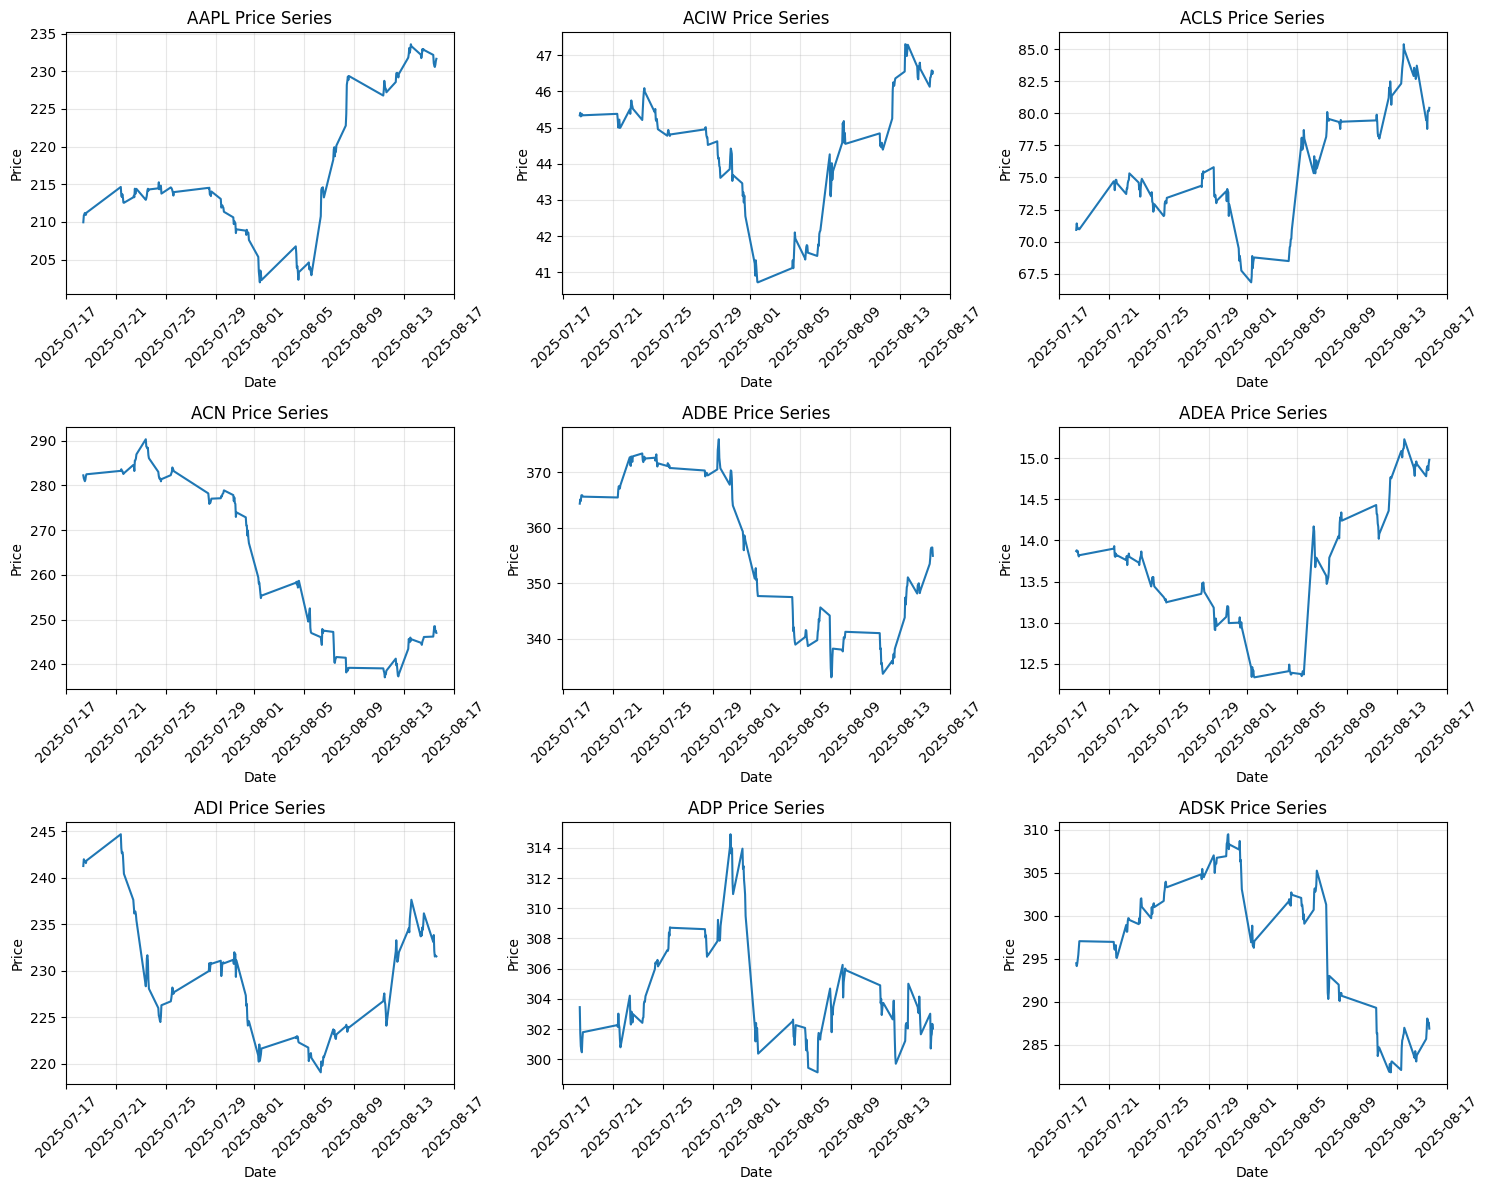

In [13]:
# Plot price series for all symbols
#fig, axes = plt.subplots(4, figsize=(15, 10))
fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows), squeeze=False)
axes = axes.flatten()

for i, symbol in enumerate(ohlc_9_df['symbol'].unique()):
    symbol_data = ohlc_9_df[ohlc_9_df['symbol'] == symbol].copy()
    symbol_data = symbol_data.sort_values('timestamp')
    
    axes[i].plot(symbol_data['timestamp'], symbol_data['close'], label=f'{symbol} Close Price')
    axes[i].set_title(f'{symbol} Price Series')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Price')
    axes[i].grid(True, alpha=0.3)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Feature Engineering

## Configuration and Parameters

In [14]:
# Window sizes for hourly data
SHORT_WINDOW = 24        # 1 day
MED_WINDOW = 120         # 5 days  
LONG_WINDOW = 480        # 20 days
VOL_WINDOWS = [12, 24, 120]  # 12h, 1d, 5d

RSI_WINDOWS = {
    'rsi_1d': 24,        # 1 day
    'rsi_3d': 72,        # 3 days
    'rsi_1w': 168,       # 1 week
    'rsi_2w': 336        # 2 weeks
}

LAG_PERIODS = [1, 2, 4, 8, 24]  # 1h, 2h, 4h, 8h, 1day
ROLLING_WINDOWS = [6, 12, 24]   # 6h, 12h, 24h windows

print("Parameters configured:")
print(f"Short window: {SHORT_WINDOW} hours")
print(f"Medium window: {MED_WINDOW} hours")
print(f"Long window: {LONG_WINDOW} hours")

Parameters configured:
Short window: 24 hours
Medium window: 120 hours
Long window: 480 hours


## Basic Price Features

In [15]:
def add_basic_price_features(group):
    """Add basic price-derived features"""
    #print(f"Processing basic features for {group['symbol'].iloc[0]}...")
    
    # Basic price features
    group['returns'] = group['close'].pct_change()
    group['log_returns'] = np.log(group['close'] / group['close'].shift(1))
    group['high_low_pct'] = (group['high'] - group['low']) / group['close']
    group['open_close_pct'] = (group['close'] - group['open']) / group['open']
    
    # Price momentum features
    group['price_acceleration'] = group['returns'].diff()  # Second derivative of price
    group['returns_sign'] = np.sign(group['returns'])  # Direction indicator
    
    return group

In [16]:
# Test with a sample
sample_df = ohlc_df[ohlc_df['symbol'] == ohlc_df['symbol'].unique()[0]].copy()
sample_df = add_basic_price_features(sample_df)
print("Basic price features added:", sample_df.columns.tolist()[-6:])

Basic price features added: ['returns', 'log_returns', 'high_low_pct', 'open_close_pct', 'price_acceleration', 'returns_sign']


## Enhanced Volatility Features

In [17]:
def add_volatility_features(group):
    """Add multiple volatility estimators"""
    #print(f"Adding volatility features for {group['symbol'].iloc[0]}...")
    
    # Basic volatility features
    group['returns_squared'] = group['returns'] ** 2
    group['realized_vol_short'] = group['returns'].rolling(VOL_WINDOWS[0]).std()
    group['realized_vol_med'] = group['returns'].rolling(VOL_WINDOWS[1]).std()
    group['realized_vol_long'] = group['returns'].rolling(VOL_WINDOWS[2]).std()
    
    # Garman-Klass volatility estimator (more efficient for OHLC data)
    gk_vol = (np.log(group['high']/group['low'])**2 - 
              (2*np.log(2)-1)*np.log(group['close']/group['open'])**2)
    group['gk_volatility'] = np.sqrt(gk_vol.rolling(24).mean())  # 1-day window
    
    # Volatility of volatility (important for regime detection)
    group['vol_of_vol'] = group['realized_vol_short'].rolling(24).std()
    
    return group

In [18]:
# Test volatility features
sample_df = add_volatility_features(sample_df)
print("Volatility features added")

Volatility features added


## Moving Average Features

In [19]:
def add_moving_average_features(group):
    """Add moving averages and related ratios"""
    #print(f"Adding moving average features for {group['symbol'].iloc[0]}...")
    
    # Moving averages
    group['price_ma_short'] = group['close'].rolling(SHORT_WINDOW).mean()
    group['price_ma_med'] = group['close'].rolling(MED_WINDOW).mean()
    group['price_ma_long'] = group['close'].rolling(LONG_WINDOW).mean()
    
    # Price to moving average ratios
    group['price_to_ma_short'] = group['close'] / group['price_ma_short']
    group['price_to_ma_med'] = group['close'] / group['price_ma_med']
    group['price_to_ma_long'] = group['close'] / group['price_ma_long']
    
    # Moving average convergence/divergence ratios
    group['ma_short_to_med'] = group['price_ma_short'] / group['price_ma_med']
    group['ma_med_to_long'] = group['price_ma_med'] / group['price_ma_long']
    
    return group

In [20]:
# Test moving average features
sample_df = add_moving_average_features(sample_df)
print("Moving average features added")

Moving average features added


## Volume Features

In [21]:
def add_volume_features(group):
    """Add volume-based features"""
    #print(f"Adding volume features for {group['symbol'].iloc[0]}...")
    
    # Basic volume features
    group['volume_ma'] = group['volume'].rolling(MED_WINDOW).mean()
    group['volume_ratio'] = group['volume'] / group['volume_ma']
    group['log_volume'] = np.log(group['volume'] + 1)
    
    # Volume-Price Trend (VPT) indicator
    group['vpt'] = (group['volume'] * group['returns']).cumsum()
    group['vpt_ma'] = group['vpt'].rolling(SHORT_WINDOW).mean()
    group['vpt_normalized'] = group['vpt'] / group['vpt_ma']
    
    # Money Flow Index components
    typical_price = (group['high'] + group['low'] + group['close']) / 3
    money_flow = typical_price * group['volume']
    positive_flow = money_flow.where(typical_price > typical_price.shift(1), 0)
    negative_flow = money_flow.where(typical_price < typical_price.shift(1), 0)
    
    money_ratio = (positive_flow.rolling(14).sum() / 
                  (negative_flow.rolling(14).sum() + 1e-10))
    group['mfi'] = 100 - (100 / (1 + money_ratio))
    
    return group

In [22]:
# Test volume features
sample_df = add_volume_features(sample_df)
print("Volume features added")

Volume features added


## RSI Features

In [23]:
def add_rsi_features(group):
    """Add multiple RSI timeframes"""
    #print(f"Adding RSI features for {group['symbol'].iloc[0]}...")
    
    # Multiple RSI timeframes
    for rsi_name, window in RSI_WINDOWS.items():
        delta = group['close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window).mean()
        rs = gain / (loss + 1e-10)
        group[rsi_name] = 100 - (100 / (1 + rs))
    
    # Exponential Moving Average RSI
    delta = group['close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    
    alpha = 2 / (14 + 1)
    avg_gain = gain.ewm(alpha=alpha, adjust=False).mean()
    avg_loss = loss.ewm(alpha=alpha, adjust=False).mean()
    rs_ema = avg_gain / (avg_loss + 1e-10)
    group['rsi_ema'] = 100 - (100 / (1 + rs_ema))
    
    return group

In [24]:
# Test RSI features
sample_df = add_rsi_features(sample_df)
print("RSI features added")

RSI features added


## Time-Based Features

In [25]:
def add_time_features(group):
    """Add time-based features for hourly data"""
    #print(f"Adding time features for {group['symbol'].iloc[0]}...")
    
    # Basic time features
    group['hour'] = group['timestamp'].dt.hour
    group['day_of_week'] = group['timestamp'].dt.dayofweek
    group['date'] = group['timestamp'].dt.date
    
    # Cyclical encoding for time features (better for neural networks)
    group['hour_sin'] = np.sin(2 * np.pi * group['hour'] / 24)
    group['hour_cos'] = np.cos(2 * np.pi * group['hour'] / 24)
    group['dow_sin'] = np.sin(2 * np.pi * group['day_of_week'] / 7)
    group['dow_cos'] = np.cos(2 * np.pi * group['day_of_week'] / 7)
    
    # Market session features
    group['is_market_open'] = ((group['hour'] >= 9) & (group['hour'] <= 16)).astype(int)
    group['is_morning'] = ((group['hour'] >= 9) & (group['hour'] <= 12)).astype(int)
    group['is_afternoon'] = ((group['hour'] >= 13) & (group['hour'] <= 16)).astype(int)
    group['hours_since_open'] = np.clip(group['hour'] - 9, 0, 7)
    group['hours_to_close'] = np.clip(16 - group['hour'], 0, 7)
    
    return group

In [26]:
# Test time features
sample_df = add_time_features(sample_df)
print("Time features added")

Time features added


## Intraday Features

In [27]:
def add_intraday_features(group):
    """Add intraday reference points with enhanced error handling"""
    #print(f"Adding intraday features for {group['symbol'].iloc[0]}...")
    
    try:
        daily_opens = group.groupby('date')['open'].transform('first')
        group['returns_from_daily_open'] = ((group['close'] - daily_opens) / 
                                           daily_opens).fillna(0)
        
        group['intraday_high'] = group.groupby('date')['high'].transform('max')
        group['intraday_low'] = group.groupby('date')['low'].transform('min')
        
        intraday_range = group['intraday_high'] - group['intraday_low']
        group['intraday_range_pct'] = (intraday_range / daily_opens).fillna(0)
        
        range_denominator = intraday_range.replace(0, np.nan)
        group['position_in_range'] = ((group['close'] - group['intraday_low']) / 
                                     range_denominator).fillna(0.5)
        
        prev_day_close = (group.groupby('date')['close']
                         .transform('last')
                         .shift(group.groupby('date').cumcount().max() + 1))
        group['overnight_gap'] = ((daily_opens - prev_day_close) / 
                                prev_day_close).fillna(0)
        
        group['dist_from_intraday_high'] = ((group['close'] - group['intraday_high']) / 
                                           group['intraday_high']).fillna(0)
        group['dist_from_intraday_low'] = ((group['close'] - group['intraday_low']) / 
                                          group['intraday_low']).fillna(0)
        
    except Exception as e:
        print(f"Warning: Error in intraday features for {group['symbol'].iloc[0]}: {e}")
        # Create dummy features if calculation fails
        for col in ['returns_from_daily_open', 'intraday_range_pct', 'position_in_range', 
                   'overnight_gap', 'dist_from_intraday_high', 'dist_from_intraday_low']:
            group[col] = 0 if 'gap' in col or 'range' in col or 'dist' in col else 0.5
    
    return group

In [28]:
# Test intraday features
sample_df = add_intraday_features(sample_df)
print("Intraday features added")

Intraday features added


## Lagged Features

In [29]:
def add_lagged_features(group):
    """Add lagged features for sequence modeling"""
    #print(f"Adding lagged features for {group['symbol'].iloc[0]}...")
    
    # Enhanced lagged features
    for lag in LAG_PERIODS:
        group[f'returns_lag_{lag}'] = group['returns'].shift(lag)
        group[f'vol_lag_{lag}'] = group['realized_vol_short'].shift(lag)
        group[f'volume_ratio_lag_{lag}'] = group['volume_ratio'].shift(lag)
    
    return group

In [30]:
# Test lagged features
sample_df = add_lagged_features(sample_df)
print("Lagged features added")

Lagged features added


## Rolling Statistics

In [31]:
def add_rolling_statistics(group):
    """Add rolling statistics for sequence modeling"""
    #print(f"Adding rolling statistics for {group['symbol'].iloc[0]}...")
    
    # Rolling statistics for different windows
    for window in ROLLING_WINDOWS:
        group[f'returns_mean_{window}h'] = group['returns'].rolling(window).mean()
        group[f'returns_std_{window}h'] = group['returns'].rolling(window).std()
        group[f'returns_skew_{window}h'] = group['returns'].rolling(window).skew()
        group[f'returns_kurt_{window}h'] = group['returns'].rolling(window).kurt()
        
        # Price momentum over different windows
        group[f'price_momentum_{window}h'] = (group['close'] / group['close'].shift(window) - 1)
    
    return group

In [32]:
# Test rolling statistics
sample_df = add_rolling_statistics(sample_df)
print("Rolling statistics added")

Rolling statistics added


## Technical Indicators

In [33]:
def add_technical_indicators(group):
    """Add technical indicators"""
    #print(f"Adding technical indicators for {group['symbol'].iloc[0]}...")
    
    # Bollinger Bands
    bb_window = SHORT_WINDOW
    bb_std = group['close'].rolling(bb_window).std()
    bb_mean = group['close'].rolling(bb_window).mean()
    group['bb_upper'] = bb_mean + (2 * bb_std)
    group['bb_lower'] = bb_mean - (2 * bb_std)
    group['bb_position'] = ((group['close'] - group['bb_lower']) / 
                           (group['bb_upper'] - group['bb_lower'] + 1e-10)).fillna(0.5)
    
    # Bollinger Band squeeze indicator
    group['bb_squeeze'] = (group['bb_upper'] - group['bb_lower']) / group['close']
    
    # MACD
    exp1 = group['close'].ewm(span=12).mean()
    exp2 = group['close'].ewm(span=26).mean()
    group['macd'] = exp1 - exp2
    group['macd_signal'] = group['macd'].ewm(span=9).mean()
    group['macd_histogram'] = group['macd'] - group['macd_signal']
    
    # Normalized MACD (scale-invariant)
    group['macd_normalized'] = group['macd'] / group['close']
    
    return group

In [34]:
# Test technical indicators
sample_df = add_technical_indicators(sample_df)
print("Technical indicators added")

Technical indicators added


## Advanced Technical Indicators

In [35]:
def add_advanced_technical_indicators(group):
    """Add advanced technical indicators"""
    #print(f"Adding advanced technical indicators for {group['symbol'].iloc[0]}...")
    
    # Average True Range (ATR) for volatility normalization
    high_low = group['high'] - group['low']
    high_close = np.abs(group['high'] - group['close'].shift(1))
    low_close = np.abs(group['low'] - group['close'].shift(1))
    true_range = np.maximum(high_low, np.maximum(high_close, low_close))
    group['atr'] = true_range.rolling(14).mean()
    group['atr_normalized'] = group['atr'] / group['close']
    
    # Williams %R
    highest_high = group['high'].rolling(14).max()
    lowest_low = group['low'].rolling(14).min()
    group['williams_r'] = -100 * ((highest_high - group['close']) / 
                                 (highest_high - lowest_low + 1e-10))
    
    return group

In [36]:
# Test advanced technical indicators
sample_df = add_advanced_technical_indicators(sample_df)
print("Advanced technical indicators added")

Advanced technical indicators added


## Main Feature Engineering Function

In [37]:
def engineer_features_for_symbol(group):
    """Apply all feature engineering steps to a single symbol"""
    group = group.sort_values('timestamp').copy()
    
    # Apply all feature engineering steps
    group = add_basic_price_features(group)
    group = add_volatility_features(group)
    group = add_moving_average_features(group)
    group = add_volume_features(group)
    group = add_rsi_features(group)
    group = add_time_features(group)
    group = add_intraday_features(group)
    group = add_lagged_features(group)
    group = add_rolling_statistics(group)
    group = add_technical_indicators(group)
    group = add_advanced_technical_indicators(group)
    
    return group

## Apply Feature Engineering to All Symbols

In [38]:
def engineer_features(df):
    """Create technical indicators and features from hourly OHLC data optimized for GRU embeddings"""
    
    print("Engineering features for hourly data...")
    
    # Apply feature engineering to each symbol
    results = []
    for symbol in df['symbol'].unique():
        symbol_data = df[df['symbol'] == symbol].copy()
        engineered_data = engineer_features_for_symbol(symbol_data)
        results.append(engineered_data)
    
    # Combine all results
    features_df = pd.concat(results, ignore_index=True)
    
    print(f"Feature engineering complete! Generated {len(features_df.columns)} features")
    print(f"Features: {features_df.columns.tolist()}")
    
    return features_df

In [39]:
from tqdm import tqdm

def engineer_features(df):
    """Create technical indicators and features from hourly OHLC data optimized for GRU embeddings"""
    
    print("Engineering features for hourly data...")
    
    # Apply feature engineering to each symbol with a progress bar
    results = []
    for symbol in tqdm(df['symbol'].unique(), desc="Processing symbols", unit="symbol"):
        symbol_data = df[df['symbol'] == symbol].copy()
        engineered_data = engineer_features_for_symbol(symbol_data)
        results.append(engineered_data)
    
    # Combine all results
    features_df = pd.concat(results, ignore_index=True)
    
    print(f"Feature engineering complete! Generated {len(features_df.columns)} features")
    print(f"Features: {features_df.columns.tolist()}")
    
    return features_df


In [40]:
# Apply to your data
features_df = engineer_features(ohlc_df)

Engineering features for hourly data...


Processing symbols: 100%|██████████| 228/228 [00:12<00:00, 18.25symbol/s]


Feature engineering complete! Generated 100 features
Features: ['symbol', 'timestamp', 'open', 'high', 'low', 'close', 'volume', 'returns', 'log_returns', 'high_low_pct', 'open_close_pct', 'price_acceleration', 'returns_sign', 'returns_squared', 'realized_vol_short', 'realized_vol_med', 'realized_vol_long', 'gk_volatility', 'vol_of_vol', 'price_ma_short', 'price_ma_med', 'price_ma_long', 'price_to_ma_short', 'price_to_ma_med', 'price_to_ma_long', 'ma_short_to_med', 'ma_med_to_long', 'volume_ma', 'volume_ratio', 'log_volume', 'vpt', 'vpt_ma', 'vpt_normalized', 'mfi', 'rsi_1d', 'rsi_3d', 'rsi_1w', 'rsi_2w', 'rsi_ema', 'hour', 'day_of_week', 'date', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'is_market_open', 'is_morning', 'is_afternoon', 'hours_since_open', 'hours_to_close', 'returns_from_daily_open', 'intraday_high', 'intraday_low', 'intraday_range_pct', 'position_in_range', 'overnight_gap', 'dist_from_intraday_high', 'dist_from_intraday_low', 'returns_lag_1', 'vol_lag_1', 'volume_ra

## Quality Check

In [41]:
def check_feature_quality(df):
    """Check the quality of engineered features"""
    print("Feature Quality Report:")
    print("=" * 50)
    
    # Check for NaN values
    nan_counts = df.isnull().sum()
    nan_features = nan_counts[nan_counts > 0]
    
    if len(nan_features) > 0:
        print(f"Features with NaN values:")
        for feature, count in nan_features.items():
            print(f"  {feature}: {count} NaN values ({count/len(df)*100:.1f}%)")
    else:
        print("✓ No NaN values found in any feature")
    
    # Check for infinite values
    inf_features = []
    for col in df.select_dtypes(include=[np.number]).columns:
        if np.isinf(df[col]).any():
            inf_count = np.isinf(df[col]).sum()
            inf_features.append((col, inf_count))
    
    if inf_features:
        print(f"\nFeatures with infinite values:")
        for feature, count in inf_features:
            print(f"  {feature}: {count} infinite values")
    else:
        print("✓ No infinite values found")
    
    # Feature statistics
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    print(f"\nFeature Statistics:")
    print(f"  Total features: {len(df.columns)}")
    print(f"  Numeric features: {len(numeric_cols)}")
    print(f"  Data points: {len(df)}")
    print(f"  Symbols: {df['symbol'].nunique()}")
    
    return df

In [42]:
# Check feature quality
features_df = check_feature_quality(features_df)

Feature Quality Report:
Features with NaN values:
  returns: 228 NaN values (0.7%)
  log_returns: 228 NaN values (0.7%)
  price_acceleration: 456 NaN values (1.4%)
  returns_sign: 228 NaN values (0.7%)
  returns_squared: 228 NaN values (0.7%)
  realized_vol_short: 2736 NaN values (8.2%)
  realized_vol_med: 5472 NaN values (16.3%)
  realized_vol_long: 27360 NaN values (81.6%)
  gk_volatility: 5244 NaN values (15.6%)
  vol_of_vol: 7980 NaN values (23.8%)
  price_ma_short: 5244 NaN values (15.6%)
  price_ma_med: 27132 NaN values (81.0%)
  price_ma_long: 33514 NaN values (100.0%)
  price_to_ma_short: 5244 NaN values (15.6%)
  price_to_ma_med: 27132 NaN values (81.0%)
  price_to_ma_long: 33514 NaN values (100.0%)
  ma_short_to_med: 27132 NaN values (81.0%)
  ma_med_to_long: 33514 NaN values (100.0%)
  volume_ma: 27132 NaN values (81.0%)
  volume_ratio: 27132 NaN values (81.0%)
  vpt: 228 NaN values (0.7%)
  vpt_ma: 5472 NaN values (16.3%)
  vpt_normalized: 5472 NaN values (16.3%)
  mfi: 296

In [43]:
# Check NaN patterns first
def analyze_nan_patterns(df):
    """Understand where and why NaNs occur"""
    nan_summary = df.isnull().sum().sort_values(ascending=False)
    print("NaN counts by feature:")
    print(nan_summary[nan_summary > 0].head(10))
    
    # Check if NaNs are mostly at the beginning (expected)
    first_valid_idx = df.first_valid_index()
    print(f"First completely valid row: {first_valid_idx}")
    
    return nan_summary

# Use this instead of dropna()
analyze_nan_patterns(features_df)

NaN counts by feature:
ma_med_to_long         33514
price_ma_long          33514
price_to_ma_long       33514
rsi_1w                 33514
rsi_2w                 33514
volume_ratio_lag_24    32604
volume_ratio_lag_8     28956
volume_ratio_lag_4     28044
volume_ratio_lag_2     27588
volume_ratio_lag_1     27360
dtype: int64
First completely valid row: 0


ma_med_to_long      33514
price_ma_long       33514
price_to_ma_long    33514
rsi_1w              33514
rsi_2w              33514
                    ...  
bb_position             0
macd_histogram          0
macd_signal             0
macd                    0
macd_normalized         0
Length: 100, dtype: int64

# Visualize Some Key Features

In [44]:
# Plot some key features for one symbol

if selected_sector == 'Utilities':
    sample_symbol = 'AEE'
elif selected_sector == 'Technology':
    sample_symbol = 'AAPL'
else :
   sample_symbol = 'ABBV'



sample_data = features_df[features_df['symbol'] == sample_symbol].copy()
sample_data = sample_data.sort_values('timestamp')
# sample_data.head(5)

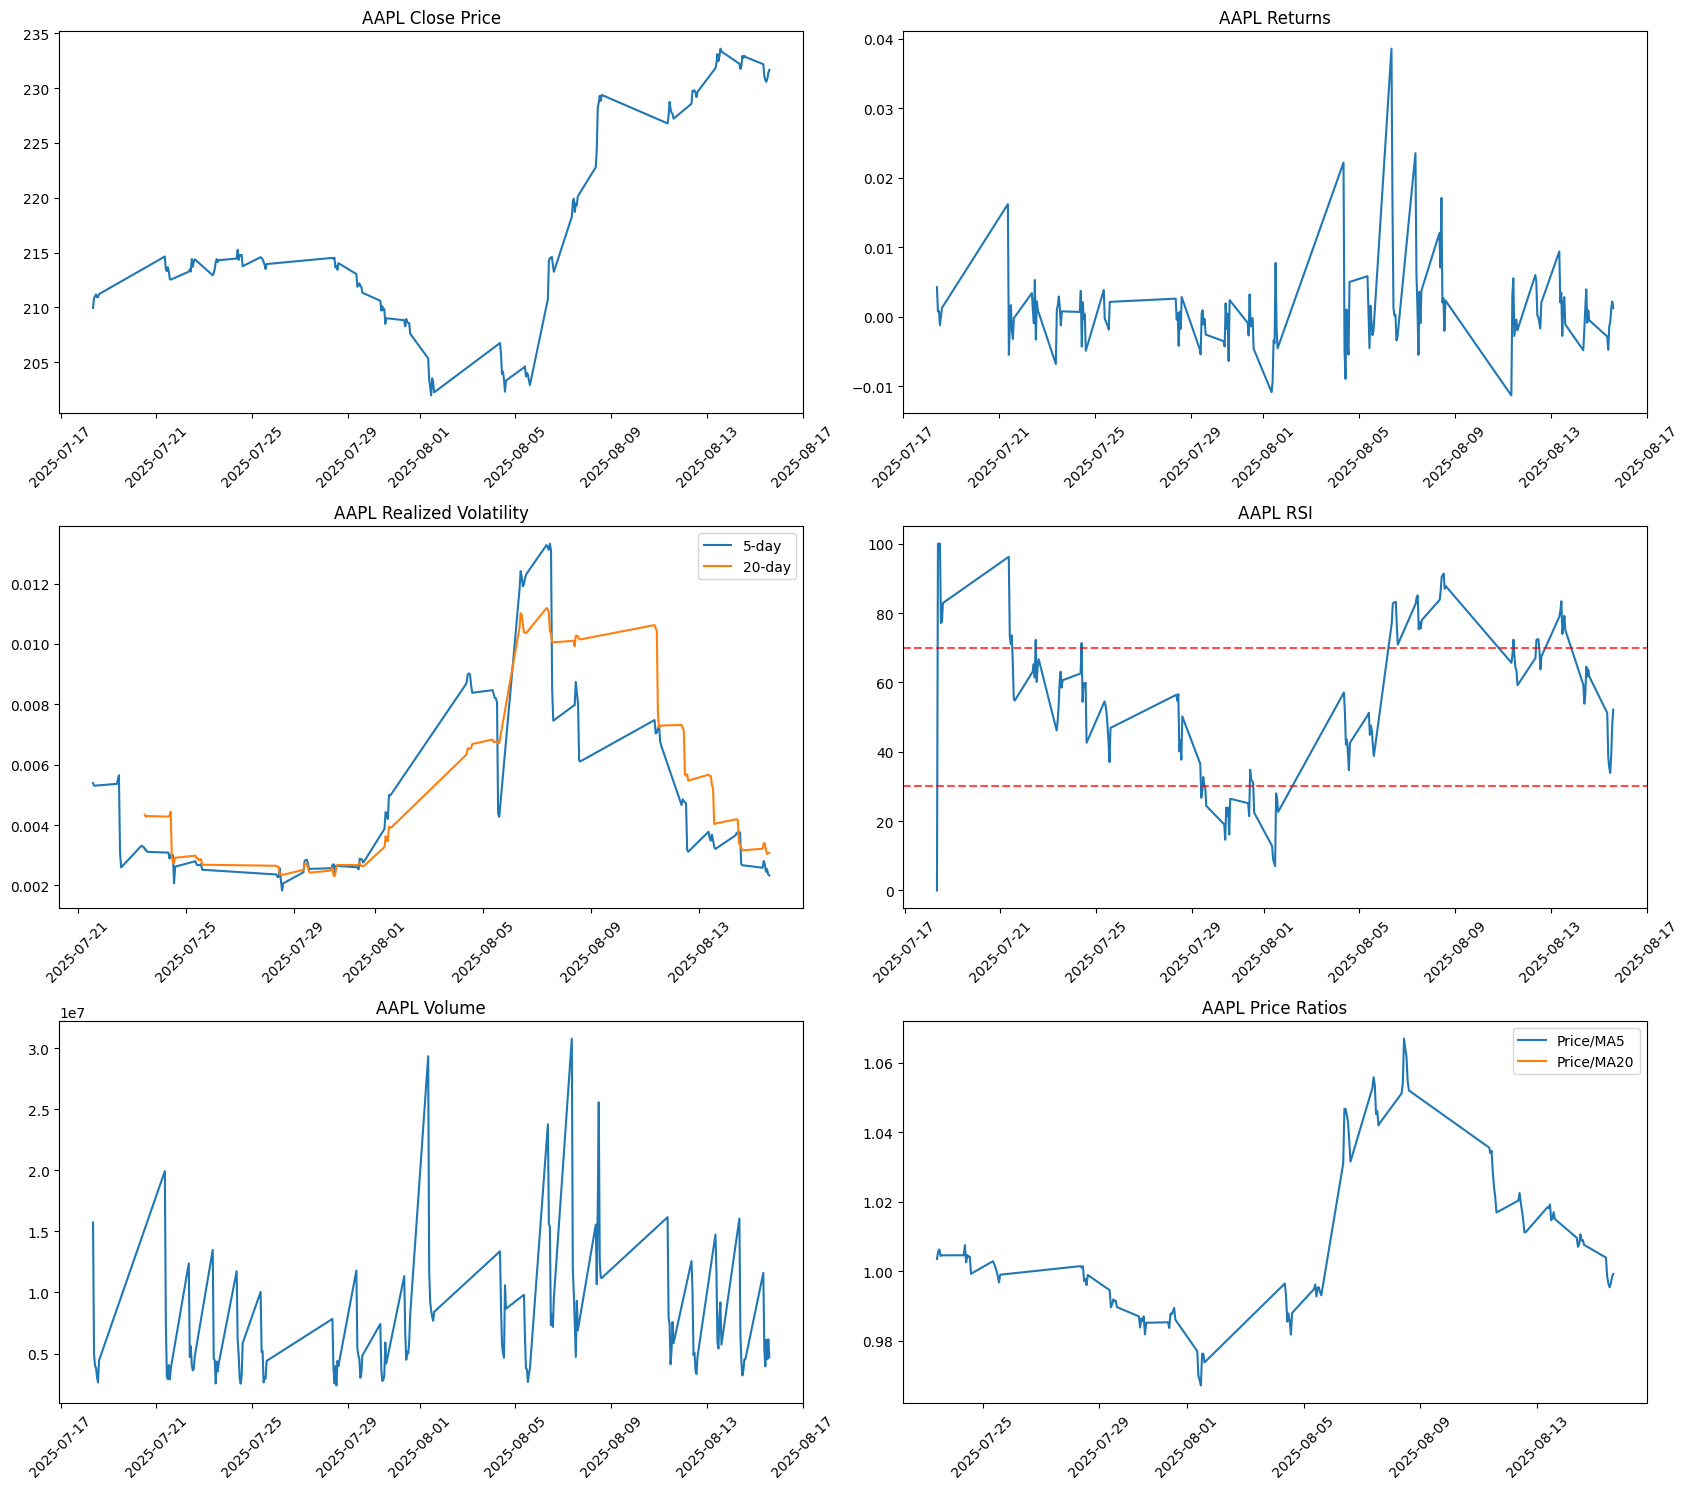

In [45]:
fig, axes = plt.subplots(3, 2, figsize=(17, 15))
#fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows), squeeze=False)

# Price and returns
axes[0,0].plot(sample_data['timestamp'], sample_data['close'])
axes[0,0].set_title(f'{sample_symbol} Close Price')
axes[0,0].tick_params(axis='x', rotation=45)

axes[0,1].plot(sample_data['timestamp'], sample_data['returns'])
axes[0,1].set_title(f'{sample_symbol} Returns')
axes[0,1].tick_params(axis='x', rotation=45)

# Volatility
axes[1,0].plot(sample_data['timestamp'], sample_data['realized_vol_short'], label='5-day')
axes[1,0].plot(sample_data['timestamp'], sample_data['realized_vol_med'], label='20-day')
axes[1,0].set_title(f'{sample_symbol} Realized Volatility')
axes[1,0].legend()
axes[1,0].tick_params(axis='x', rotation=45)

# RSI
axes[1,1].plot(sample_data['timestamp'], sample_data['rsi_ema'])
axes[1,1].axhline(y=70, color='r', linestyle='--', alpha=0.7)
axes[1,1].axhline(y=30, color='r', linestyle='--', alpha=0.7)
axes[1,1].set_title(f'{sample_symbol} RSI')
axes[1,1].tick_params(axis='x', rotation=45)

# Volume
axes[2,0].plot(sample_data['timestamp'], sample_data['volume'])
axes[2,0].set_title(f'{sample_symbol} Volume')
axes[2,0].tick_params(axis='x', rotation=45)

# Price ratios
axes[2,1].plot(sample_data['timestamp'], sample_data['price_to_ma_short'], label='Price/MA5')
axes[2,1].plot(sample_data['timestamp'], sample_data['price_to_ma_long'], label='Price/MA20')
axes[2,1].set_title(f'{sample_symbol} Price Ratios')
axes[2,1].legend()
axes[2,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Create Sequences for Training

## Configurations and Parameters

In [46]:
# Sequence creation parameters
SEQUENCE_LENGTH = 48        # 48 hours = 2 days of hourly data
TARGET_HORIZON = 1          # Reserve space for future prediction (not used for embeddings)
MIN_VALID_RATIO = 0.65      # Lowered from 0.95 due to long rolling windows (20-day MA, 2w RSI)

print("Sequence Parameters:")
print(f"Sequence Length: {SEQUENCE_LENGTH} hours")
print(f"Minimum Valid Data Ratio: {MIN_VALID_RATIO*100}%")
print(f"Target Horizon: {TARGET_HORIZON} hour(s)")  # Added for completeness

Sequence Parameters:
Sequence Length: 48 hours
Minimum Valid Data Ratio: 65.0%
Target Horizon: 1 hour(s)


## Data Preparation Function

In [47]:
def prepare_features_for_sequences(features_df):
    """Prepare feature data and get column information"""
    
    # Get feature columns (exclude non-numeric columns)
    feature_cols = features_df.select_dtypes(include=[np.number]).columns.tolist()
    
    # Remove columns we don't want in sequences
    exclude_cols = ['date']  # 'date' is often object type anyway, but good to be explicit
    feature_cols = [col for col in feature_cols if col not in exclude_cols]
    
    print(f"Feature Preparation:")
    print(f"Total columns in dataframe: {len(features_df.columns)}")
    print(f"Numeric feature columns: {len(feature_cols)}")
    print(f"Excluded columns: {exclude_cols}")  # Show what was excluded
    
    # Get symbol information  
    unique_symbols = features_df['symbol'].unique()
    print(f"Unique symbols: {len(unique_symbols)}")
    print(f"Date range: {features_df['timestamp'].min()} to {features_df['timestamp'].max()}")  # Added data range
    
    return feature_cols, unique_symbols

In [48]:
# Prepare features
feature_columns, symbols_list = prepare_features_for_sequences(features_df)
print(f"\n✅ Ready to process {len(symbols_list)} symbols with {len(feature_columns)} features")

# Quick sanity check
if len(feature_columns) == 0:
    print("❌ ERROR: No feature columns found!")
elif len(symbols_list) == 0:
    print("❌ ERROR: No symbols found!")
else:
    print(f"📊 Expected sequences per symbol: ~{len(features_df) // len(symbols_list) - SEQUENCE_LENGTH}")

Feature Preparation:
Total columns in dataframe: 100
Numeric feature columns: 97
Excluded columns: ['date']
Unique symbols: 228
Date range: 2025-07-18 08:30:00 to 2025-08-15 14:30:00

✅ Ready to process 228 symbols with 97 features
📊 Expected sequences per symbol: ~98


## Data Quality Check Function

In [49]:
def check_sequence_quality(sequence_data, min_valid_ratio=MIN_VALID_RATIO):
    """Check if a sequence meets quality requirements"""
    
    # Handle empty data
    if sequence_data.empty:
        return False, 0.0
    
    total_values = sequence_data.size
    valid_values = sequence_data.count().sum()  # Count non-NaN values
    valid_ratio = valid_values / total_values if total_values > 0 else 0.0
    
    return valid_ratio >= min_valid_ratio, valid_ratio

In [50]:
# Test the quality check function
sample_symbol = features_df['symbol'].iloc[0]
sample_data = features_df[features_df['symbol'] == sample_symbol].head(SEQUENCE_LENGTH)

print(f"Testing with symbol: {sample_symbol}")
print(f"Sample data shape: {sample_data[feature_columns].shape}")

is_valid, ratio = check_sequence_quality(sample_data[feature_columns])
print(f"Sample quality check - Valid: {is_valid}, Ratio: {ratio:.3f}")

# Additional diagnostics
if not is_valid:
    print(f"❌ Quality check failed: {ratio:.1%} < {MIN_VALID_RATIO:.1%}")
    print(f"Need {(MIN_VALID_RATIO - ratio) * sample_data[feature_columns].size:.0f} more valid values")
else:
    print(f"✅ Quality check passed: {ratio:.1%} >= {MIN_VALID_RATIO:.1%}")

Testing with symbol: AAPL
Sample data shape: (48, 97)
Sample quality check - Valid: True, Ratio: 0.676
✅ Quality check passed: 67.6% >= 65.0%


## NaN Handling Function

In [51]:
def clean_sequence_data(sequence_data):
    """Clean sequence data by handling NaN values with multiple strategies"""
    
    # Handle empty data
    if sequence_data.empty:
        return sequence_data.copy(), True
    
    sequence_clean = sequence_data.copy()
    initial_nans = sequence_clean.isnull().sum().sum()
    
    # Strategy 1: Forward fill then backward fill
    sequence_clean = sequence_clean.ffill().bfill()
    nans_after_fill = sequence_clean.isnull().sum().sum()
    
    # Strategy 2: If still NaNs, fill with column means
    if nans_after_fill > 0:
        column_means = sequence_clean.mean()
        # Only fill columns that have valid means (avoid NaN means)
        for col in sequence_clean.columns:
            if sequence_clean[col].isnull().any() and not pd.isna(column_means[col]):
                sequence_clean[col].fillna(column_means[col], inplace=True)
    
    nans_after_mean = sequence_clean.isnull().sum().sum()
    
    # Strategy 3: If still NaNs (shouldn't happen), fill with 0
    if nans_after_mean > 0:
        sequence_clean = sequence_clean.fillna(0)
        # Uncomment for debugging: print(f"Warning: {nans_after_mean} NaNs filled with 0 as last resort")
    
    # Final check
    remaining_nans = sequence_clean.isnull().sum().sum()
    
    return sequence_clean, remaining_nans == 0

In [52]:
# Enhanced test with more diagnostics
print(f"Original sample NaNs: {sample_data[feature_columns].isnull().sum().sum()}")

if sample_data[feature_columns].isnull().any().any():
    cleaned_sample, is_clean = clean_sequence_data(sample_data[feature_columns])
    print(f"After cleaning - NaNs: {cleaned_sample.isnull().sum().sum()}")
    print(f"Cleaning successful: {is_clean}")
    
    # Show which strategies were needed
    if is_clean:
        print("✅ All NaNs successfully handled")
    else:
        print(f"❌ {cleaned_sample.isnull().sum().sum()} NaNs remain")
        
else:
    print("✅ Sample data was already clean - no NaNs found")

# Verify data integrity
print(f"Sample shape maintained: {sample_data[feature_columns].shape} -> {cleaned_sample.shape if 'cleaned_sample' in locals() else 'N/A'}")

Original sample NaNs: 1510
After cleaning - NaNs: 0
Cleaning successful: True
✅ All NaNs successfully handled
Sample shape maintained: (48, 97) -> (48, 97)


In [53]:
cleaned_sample.head(5)

,open,high,low,close,volume,returns,log_returns,high_low_pct,open_close_pct,price_acceleration,...,bb_lower,bb_position,bb_squeeze,macd,macd_signal,macd_histogram,macd_normalized,atr,atr_normalized,williams_r
0,210.755,211.01,209.7045,209.9543,15729684,0.004266,0.004257,0.006218,-0.003799,-0.003507,...,210.054597,0.5,0.025214,0.000000,0.000000,0.000000,0.000000,1.181321,0.005539,-53.328944
1,209.960,211.01,209.7700,210.8500,4957360,0.004266,0.004257,0.005881,0.004239,-0.003507,...,210.054597,0.5,0.025214,0.020096,0.011164,0.008931,0.000095,1.181321,0.005539,-53.328944
2,210.855,211.13,210.6800,211.0100,3993353,0.000759,0.000759,0.002133,0.000735,-0.003507,...,210.054597,0.5,0.025214,0.030568,0.019117,0.011451,0.000145,1.181321,0.005539,-53.328944
3,211.020,211.79,210.8800,211.1900,3840387,0.000853,0.000853,0.004309,0.000806,0.000094,...,210.054597,0.5,0.025214,0.041080,0.026557,0.014523,0.000195,1.181321,0.005539,-53.328944
4,211.180,211.54,210.7600,210.9350,3054294,-0.001207,-0.001208,0.003698,-0.001160,-0.002060,...,210.054597,0.5,0.025214,0.035781,0.029301,0.006480,0.000170,1.181321,0.005539,-53.328944


## Symbol Processing

In [54]:
def create_sequences_streamlined(features_df, feature_cols, sequence_length=SEQUENCE_LENGTH, 
                               stride=1, min_valid_ratio=MIN_VALID_RATIO):
    """Streamlined sequence creation using your tested functions"""
    
    print(f"Creating sequences with length {sequence_length}")
    print(f"Using minimum valid ratio: {min_valid_ratio}")
    
    sequences = []
    symbols_list = []
    timestamps_list = []
    total_skipped = 0
    
    for symbol in tqdm(features_df['symbol'].unique(), desc="Processing symbols"):
        symbol_data = features_df[features_df['symbol'] == symbol].sort_values('timestamp')
        
        # Skip if insufficient data
        if len(symbol_data) < sequence_length:
            continue
            
        # Create sequences with stride
        for start_idx in range(0, len(symbol_data) - sequence_length + 1, stride):
            window = symbol_data[feature_cols].iloc[start_idx:start_idx + sequence_length]
            
            # Use your tested quality check function
            is_valid, valid_ratio = check_sequence_quality(window, min_valid_ratio)
            
            if not is_valid:
                total_skipped += 1
                continue
                
            # Use your tested cleaning function
            window_clean, is_clean = clean_sequence_data(window)
            
            if not is_clean:
                total_skipped += 1
                continue
            
            # Add valid sequence
            sequences.append(window_clean.values)
            symbols_list.append(symbol)
            timestamps_list.append(symbol_data['timestamp'].iloc[start_idx + sequence_length - 1])
    
    sequences_array = np.array(sequences, dtype=np.float32)
    print(f"✅ Created {len(sequences_array)} sequences of shape {sequences_array.shape}")
    print(f"⚠️  Skipped {total_skipped} sequences due to quality issues")
    
    return sequences_array, symbols_list, timestamps_list

In [ ]:
# Use it with your existing tested parameters
sequences, sequence_symbols, sequence_timestamps = create_sequences_streamlined(
    features_df, 
    feature_cols=feature_columns,  # Use your prepared feature columns
    sequence_length=SEQUENCE_LENGTH,
    min_valid_ratio=MIN_VALID_RATIO
)

Creating sequences with length 48
Using minimum valid ratio: 0.65


Processing symbols:   1%|▏         | 3/228 [00:03<04:19,  1.15s/it]

## Feature Normalization

In [ ]:
def detect_outliers(sequences, feature_columns, method='iqr', factor=3.0):
    """
    Simple outlier detection that returns results as DataFrame
    
    Parameters:
    -----------
    sequences : np.array (n_sequences, sequence_length, n_features)
    feature_columns : list of feature names
    method : 'iqr' or 'zscore'
    factor : multiplier for detection threshold
    
    Returns:
    --------
    outlier_stats : pd.DataFrame with outlier statistics
    """
    stats_list = []
    
    for feat_idx, feature_name in enumerate(feature_columns):
        # Get all values for this feature
        feature_data = sequences[:, :, feat_idx].flatten()
        feature_data = feature_data[np.isfinite(feature_data)]
        
        if method == 'iqr':
            Q1, Q3 = np.percentile(feature_data, [25, 75])
            IQR = Q3 - Q1
            lower_bound = Q1 - factor * IQR
            upper_bound = Q3 + factor * IQR
        else:  # zscore
            mean_val = np.mean(feature_data)
            std_val = np.std(feature_data)
            lower_bound = mean_val - factor * std_val
            upper_bound = mean_val + factor * std_val
        
        # Count outliers
        outliers = (feature_data < lower_bound) | (feature_data > upper_bound)
        outlier_count = np.sum(outliers)
        outlier_percentage = (outlier_count / len(feature_data)) * 100
        
        stats_list.append({
            'feature': feature_name,
            'outlier_count': outlier_count,
            'outlier_percentage': round(outlier_percentage, 2),
            'lower_bound': round(lower_bound, 4),
            'upper_bound': round(upper_bound, 4),
            'original_min': round(np.min(feature_data), 4),
            'original_max': round(np.max(feature_data), 4),
            'method': method
        })
    
    return pd.DataFrame(stats_list)

In [ ]:
def clip_outliers(sequences, feature_columns, method='iqr', factor=3.0):
    """
    Remove outliers by clipping to bounds
    
    Returns:
    --------
    sequences_clean : np.array with outliers clipped
    outlier_stats : pd.DataFrame with statistics
    """
    sequences_clean = sequences.copy()
    outlier_stats = detect_outliers(sequences, feature_columns, method, factor)
    
    for idx, row in outlier_stats.iterrows():
        feat_idx = feature_columns.index(row['feature'])
        sequences_clean[:, :, feat_idx] = np.clip(
            sequences_clean[:, :, feat_idx], 
            row['lower_bound'], 
            row['upper_bound']
        )
    
    return sequences_clean, outlier_stats

In [ ]:
def normalize_data(sequences, feature_columns, method='robust'):
    """
    Simple global normalization
    
    Parameters:
    -----------
    method : 'robust', 'standard', or 'minmax'
    
    Returns:
    --------
    normalized_sequences : np.array
    norm_params : pd.DataFrame with normalization parameters
    """
    normalized_sequences = sequences.copy()
    params_list = []
    
    for feat_idx, feature_name in enumerate(feature_columns):
        feature_data = sequences[:, :, feat_idx].flatten()
        feature_data = feature_data[np.isfinite(feature_data)]
        
        if method == 'robust':
            center = np.median(feature_data)
            scale = np.percentile(feature_data, 75) - np.percentile(feature_data, 25)
        elif method == 'standard':
            center = np.mean(feature_data)
            scale = np.std(feature_data)
        else:  # minmax
            center = np.min(feature_data)
            scale = np.max(feature_data) - np.min(feature_data)
        
        # Avoid division by zero
        if scale < 1e-10:
            scale = 1.0
        
        # Apply normalization
        if method == 'minmax':
            normalized_sequences[:, :, feat_idx] = (sequences[:, :, feat_idx] - center) / scale
        else:
            normalized_sequences[:, :, feat_idx] = (sequences[:, :, feat_idx] - center) / scale
        
        params_list.append({
            'feature': feature_name,
            'center': round(center, 6),
            'scale': round(scale, 6),
            'method': method
        })
    
    norm_params = pd.DataFrame(params_list)
    return normalized_sequences, norm_params

In [ ]:
def validate_normalization(original, normalized, feature_columns):
    """
    Validate normalization results
    
    Returns:
    --------
    validation_stats : pd.DataFrame with validation metrics
    """
    stats_list = []
    
    # Overall stats
    overall_stats = {
        'feature': 'OVERALL',
        'nan_count': int(np.isnan(normalized).sum()),
        'inf_count': int(np.isinf(normalized).sum()),
        'mean_before': round(np.nanmean(original), 4),
        'std_before': round(np.nanstd(original), 4),
        'mean_after': round(np.nanmean(normalized), 4),
        'std_after': round(np.nanstd(normalized), 4),
        'min_after': round(np.nanmin(normalized), 4),
        'max_after': round(np.nanmax(normalized), 4)
    }
    stats_list.append(overall_stats)
    
    # Per-feature stats
    for i, feature in enumerate(feature_columns):
        orig_data = original[:, :, i].flatten()
        norm_data = normalized[:, :, i].flatten()
        
        feature_stats = {
            'feature': feature,
            'nan_count': int(np.isnan(norm_data).sum()),
            'inf_count': int(np.isinf(norm_data).sum()),
            'mean_before': round(np.nanmean(orig_data), 4),
            'std_before': round(np.nanstd(orig_data), 4),
            'mean_after': round(np.nanmean(norm_data), 4),
            'std_after': round(np.nanstd(norm_data), 4),
            'min_after': round(np.nanmin(norm_data), 4),
            'max_after': round(np.nanmax(norm_data), 4)
        }
        stats_list.append(feature_stats)
    
    return pd.DataFrame(stats_list)

In [ ]:
def plot_before_after(original, normalized, feature_columns, n_features=4):
    """
    Simple before/after comparison plots
    """
    n_features = min(n_features, len(feature_columns))
    fig, axes = plt.subplots(2, n_features, figsize=(4*n_features, 8))
    
    if n_features == 1:
        axes = axes.reshape(-1, 1)
    
    for i in range(n_features):
        feature = feature_columns[i]
        
        # Original data
        orig_data = original[:, :, i].flatten()
        orig_data = orig_data[np.isfinite(orig_data)]
        
        # Normalized data
        norm_data = normalized[:, :, i].flatten()
        norm_data = norm_data[np.isfinite(norm_data)]
        
        # Plot histograms
        axes[0, i].hist(orig_data, bins=50, alpha=0.7, color='red', density=True)
        axes[0, i].set_title(f'Before: {feature}')
        axes[0, i].set_ylabel('Density')
        
        axes[1, i].hist(norm_data, bins=50, alpha=0.7, color='green', density=True)
        axes[1, i].set_title(f'After: {feature}')
        axes[1, i].set_ylabel('Density')
    
    plt.tight_layout()
    plt.show()

In [ ]:
# Step by step approach:
outlier_stats = detect_outliers(sequences, feature_columns)
sequences_clean, _ = clip_outliers(sequences, feature_columns)
normalized_sequences, norm_params = normalize_data(sequences_clean, feature_columns)
validation = validate_normalization(sequences, normalized_sequences, feature_columns)

### View results as DataFrames

In [ ]:
outlier_stats.head(5)

In [ ]:
norm_params.head(5)

In [ ]:
validation.head(5)

In [ ]:
# Plot comparison
plot_before_after(sequences, normalized_sequences, feature_columns)

In [ ]:
# Quick device info
print(f"Tensor device: {normalized_sequences.device}")

In [ ]:
normalized_sequences[:1]

## Visualization

In [ ]:
def analyze_sequences_comprehensive(sequences, feature_columns, sequence_symbols, sequence_timestamps):
    """
    Comprehensive analysis of your sequences
    """
    print("🔍 SEQUENCE ANALYSIS REPORT")
    print("=" * 50)
    
    # Basic stats
    n_sequences, seq_length, n_features = sequences.shape
    print(f"📊 Dataset Overview:")
    print(f"   • Total sequences: {n_sequences:,}")
    print(f"   • Sequence length: {seq_length} hours")
    print(f"   • Number of features: {n_features}")
    print(f"   • Total data points: {n_sequences * seq_length * n_features:,}")
    
    # Symbol distribution
    symbol_counts = pd.Series(sequence_symbols).value_counts()
    print(f"\n📈 Symbol Distribution:")
    print(f"   • Unique symbols: {len(symbol_counts)}")
    print(f"   • Sequences per symbol: {symbol_counts.mean():.1f} ± {symbol_counts.std():.1f}")
    print(f"   • Min/Max sequences: {symbol_counts.min()}/{symbol_counts.max()}")
    
    # Data quality
    total_values = sequences.size
    finite_values = np.isfinite(sequences).sum()
    print(f"\n✅ Data Quality:")
    print(f"   • Finite values: {finite_values:,}/{total_values:,} ({finite_values/total_values*100:.2f}%)")
    print(f"   • NaN values: {np.isnan(sequences).sum():,}")
    print(f"   • Infinite values: {np.isinf(sequences).sum():,}")
    
    # Feature statistics
    #print(f"\n📋 Feature Statistics:")
    #for i, feature in enumerate(feature_columns):
    #    feature_data = sequences[:, :, i]
    #    print(f"   • {feature}:")
    #    print(f"     - Range: [{np.nanmin(feature_data):.4f}, {np.nanmax(feature_data):.4f}]")
    #    print(f"     - Mean: {np.nanmean(feature_data):.4f} ± {np.nanstd(feature_data):.4f}")
    
    return symbol_counts

In [ ]:
def plot_sequence_overview(sequences, feature_columns, sequence_symbols):
    """
    Create overview plots of your sequences
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('📊 Sequence Dataset Overview', fontsize=16, fontweight='bold', y=0.98)
    
    # 1. Sequence length distribution (if varies)
    ax1 = axes[0, 0]
    seq_lengths = [sequences.shape[1]] * sequences.shape[0]  # All same length in your case
    ax1.bar(['Sequence Length'], [sequences.shape[1]], color='skyblue', alpha=0.7)
    ax1.set_title('Sequence Length Distribution', fontweight='bold')
    ax1.set_ylabel('Hours')
    ax1.text(0, sequences.shape[1]/2, f'{sequences.shape[1]}h\n(2 days)', 
             ha='center', va='center', fontweight='bold', fontsize=12)
    
    # 2. Symbol frequency
    ax2 = axes[0, 1]
    symbol_counts = pd.Series(sequence_symbols).value_counts()
    top_10_symbols = symbol_counts.head(10)
    ax2.bar(range(len(top_10_symbols)), top_10_symbols.values, color='lightgreen', alpha=0.7)
    ax2.set_title('Top 10 Symbols by Sequence Count', fontweight='bold')
    ax2.set_xlabel('Symbols')
    ax2.set_ylabel('Number of Sequences')
    ax2.set_xticks(range(len(top_10_symbols)))
    ax2.set_xticklabels(top_10_symbols.index, rotation=45)
    
    # 3. Feature value distributions
    ax3 = axes[1, 0]
    feature_means = []
    feature_stds = []
    for i in range(len(feature_columns)):
        feature_data = sequences[:, :, i].flatten()
        feature_means.append(np.nanmean(feature_data))
        feature_stds.append(np.nanstd(feature_data))
    
    x_pos = np.arange(len(feature_columns))
    ax3.bar(x_pos, feature_means, yerr=feature_stds, capsize=3, color='orange', alpha=0.7)
    ax3.set_title('Feature Means ± Std Dev', fontweight='bold')
    ax3.set_xlabel('Features')
    ax3.set_ylabel('Values')
    ax3.set_xticks(x_pos)
    ax3.set_xticklabels([f'F{i+1}' for i in range(len(feature_columns))], rotation=45)
    
    # 4. Data completeness heatmap
    ax4 = axes[1, 1]
    # Calculate completeness per feature per sequence (sample)
    sample_sequences = min(20, sequences.shape[0])
    completeness = np.zeros((sample_sequences, len(feature_columns)))
    for i in range(sample_sequences):
        for j in range(len(feature_columns)):
            completeness[i, j] = np.isfinite(sequences[i, :, j]).mean()
    
    im = ax4.imshow(completeness, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
    ax4.set_title(f'Data Completeness\n(Sample of {sample_sequences} sequences)', fontweight='bold')
    ax4.set_xlabel('Features')
    ax4.set_ylabel('Sequences')
    ax4.set_xticks(range(len(feature_columns)))
    ax4.set_xticklabels([f'F{i+1}' for i in range(len(feature_columns))])
    
    # Add colorbar
    plt.colorbar(im, ax=ax4, fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_sample_sequences(sequences, feature_columns, n_samples=4):
    """
    Plot sample sequences to understand the data patterns
    """
    fig, axes = plt.subplots(n_samples, 1, figsize=(15, 3*n_samples))
    if n_samples == 1:
        axes = [axes]
    
    fig.suptitle('🔍 Sample Sequence Patterns', fontsize=16, fontweight='bold', y=0.98)
    
    # Select random sequences
    sample_indices = np.random.choice(sequences.shape[0], n_samples, replace=False)
    
    for i, seq_idx in enumerate(sample_indices):
        ax = axes[i]
        sequence_data = sequences[seq_idx]  # Shape: (48, n_features)
        
        # Plot each feature
        for feat_idx in range(min(5, len(feature_columns))):  # Limit to 5 features for readability
            ax.plot(sequence_data[:, feat_idx], 
                   label=f'{feature_columns[feat_idx][:15]}...', 
                   linewidth=1.5, alpha=0.8)
        
        ax.set_title(f'Sequence #{seq_idx} - 48 Hour Window', fontweight='bold')
        ax.set_xlabel('Hours')
        ax.set_ylabel('Normalized Values')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(True, alpha=0.3)
        ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_feature_correlations(sequences, feature_columns):
    """
    Analyze correlations between features
    """
    # Flatten sequences to get all data points
    n_sequences, seq_length, n_features = sequences.shape
    flattened_data = sequences.reshape(-1, n_features)
    
    # Create correlation matrix
    corr_df = pd.DataFrame(flattened_data, columns=feature_columns)
    correlation_matrix = corr_df.corr()
    
    # Plot heatmap
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, 
                mask=mask, 
                annot=True, 
                cmap='RdBu_r', 
                center=0,
                square=True,
                fmt='.2f',
                cbar_kws={"shrink": .8})
    
    plt.title('🔗 Feature Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Print highly correlated pairs
    print("🔗 Highly Correlated Feature Pairs (|r| > 0.7):")
    print("-" * 50)
    high_corr_pairs = []
    for i in range(len(feature_columns)):
        for j in range(i+1, len(feature_columns)):
            corr_val = correlation_matrix.iloc[i, j]
            if abs(corr_val) > 0.7:
                high_corr_pairs.append((feature_columns[i], feature_columns[j], corr_val))
    
    if high_corr_pairs:
        for feat1, feat2, corr in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True):
            print(f"   • {feat1} ↔ {feat2}: {corr:.3f}")
    else:
        print("   • No highly correlated pairs found")

In [ ]:
def plot_normalization_effects(original_sequences, normalized_sequences, feature_columns):
    """
    Compare before and after normalization
    """
    n_features = len(feature_columns)
    fig, axes = plt.subplots(2, min(4, n_features), figsize=(16, 8))
    if n_features == 1:
        axes = axes.reshape(2, 1)
    
    fig.suptitle('🎯 Normalization Effects (Before vs After)', fontsize=16, fontweight='bold', y=0.98)
    
    for i in range(min(4, n_features)):
        # Before normalization
        original_data = original_sequences[:, :, i].flatten()
        axes[0, i].hist(original_data, bins=50, alpha=0.7, color='red', density=True)
        axes[0, i].set_title(f'Before: {feature_columns[i][:15]}...', fontweight='bold')
        axes[0, i].set_ylabel('Density')
        axes[0, i].text(0.02, 0.98, f'μ={np.nanmean(original_data):.2f}\nσ={np.nanstd(original_data):.2f}', 
                       transform=axes[0, i].transAxes, va='top', fontsize=10,
                       bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
        
        # After normalization
        normalized_data = normalized_sequences[:, :, i].flatten()
        axes[1, i].hist(normalized_data, bins=50, alpha=0.7, color='green', density=True)
        axes[1, i].set_title(f'After: {feature_columns[i][:15]}...', fontweight='bold')
        axes[1, i].set_xlabel('Value')
        axes[1, i].set_ylabel('Density')
        axes[1, i].text(0.02, 0.98, f'μ={np.nanmean(normalized_data):.2f}\nσ={np.nanstd(normalized_data):.2f}', 
                       transform=axes[1, i].transAxes, va='top', fontsize=10,
                       bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    
    plt.tight_layout()
    plt.show()

In [ ]:
print("\n" + "="*60)
print("📈 SEQUENCE DATASET ANALYSIS COMPLETE")
print("="*60)
# Run all analyses
print("\n1️⃣ Running comprehensive analysis...")
symbol_counts = analyze_sequences_comprehensive(normalized_sequences, feature_columns, sequence_symbols, sequence_timestamps)

In [ ]:
print("\n2️⃣ Generating overview plots...")
plot_sequence_overview(normalized_sequences, feature_columns, sequence_symbols)

In [ ]:
print("\n3️⃣ Plotting sample sequences...")
plot_sample_sequences(sequences, feature_columns)

In [ ]:
# If you want to compare normalization effects:
plot_normalization_effects(sequences, normalized_sequences, feature_columns)

In [ ]:
# Summary recommendations
print("\n🎯 RECOMMENDATIONS FOR GRU TRAINING:")
print("-" * 40)
print(f"✅ Dataset size: {normalized_sequences.shape[0]:,} sequences is good for training")
print(f"✅ Sequence length: {normalized_sequences.shape[1]} hours captures short-term patterns")
print(f"✅ Feature count: {normalized_sequences.shape[2]} features - consider dimensionality")
print(f"💡 Consider batch size: {min(32, normalized_sequences.shape[0]//10)} - {min(128, normalized_sequences.shape[0]//5)}")
print(f"💡 Train/Val split suggestion: 80/20 = {int(normalized_sequences.shape[0]*0.8)}/{int(normalized_sequences.shape[0]*0.2)}")

if normalized_sequences.shape[2] > 20:
    print("⚠️  Consider feature selection or PCA - many features may cause overfitting")

## Save

In [ ]:
def save_sequences(sequences, symbols, timestamps,  selected_sector, filename_prefix='gru_sequences'):
    """Save sequences and metadata"""
    
    if not validate_normalization:
        print("Validation failed, not saving sequences")
        return
    
    # Save sequences as numpy array
    np.save(f'{filename_prefix}_{selected_sector}_data.npy', sequences)
    
    # Save metadata as DataFrame
    metadata = pd.DataFrame({
        'symbol': symbols,
        'timestamp': timestamps
    })
    metadata.to_csv(f'{filename_prefix}_{selected_sector}_metadata.csv', index=False)
    
    # Save configuration
    config = {
        'sequence_length': SEQUENCE_LENGTH,
        'target_horizon': TARGET_HORIZON,
        'min_valid_ratio': MIN_VALID_RATIO,
        'n_features': len(feature_columns),
        'n_sequences': len(sequences),
        'n_symbols': len(set(symbols))
    }
    
    config_df = pd.DataFrame([config])
    config_df.to_csv(f'{filename_prefix}_{selected_sector}_config.csv', index=False)
    
    print(f"Sequences saved:")
    print(f"  Data: {filename_prefix}_{selected_sector}_data.npy")
    print(f"  Metadata: {filename_prefix}_{selected_sector}_metadata.csv") 
    print(f"  Config: {filename_prefix}_{selected_sector}_config.csv")

In [ ]:
# Optionally save results
save_sequences(normalized_sequences, sequence_symbols, sequence_timestamps, selected_sector)
print("Sequence creation complete! Ready for GRU model training.")

## Data Split

In [ ]:
def create_chronological_splits_updated(sequences, dates, symbols, 
                                      train_months=8, val_months=2):
    """
    Updated splitting for your 2024-2025 data range
    Auto-calculates split points based on your data span
    """
    start_date = dates.min()
    end_date = dates.max()
    total_days = (end_date - start_date).days
    
    print(f"Data spans {total_days} days from {start_date.date()} to {end_date.date()}")
    
    # Calculate split points based on proportions
    train_ratio = train_months / (train_months + val_months + 2)  # 8/12 = 67%
    val_ratio = val_months / (train_months + val_months + 2)      # 2/12 = 17%
    # test gets remaining 16%
    
    # Calculate actual split dates
    train_end = start_date + pd.Timedelta(days=int(total_days * train_ratio))
    val_end = start_date + pd.Timedelta(days=int(total_days * (train_ratio + val_ratio)))
    
    print(f"Split points:")
    print(f"  Train: {start_date.date()} to {train_end.date()}")
    print(f"  Val:   {train_end.date()} to {val_end.date()}")  
    print(f"  Test:  {val_end.date()} to {end_date.date()}")
    
    # Create masks
    train_mask = dates <= train_end
    val_mask = (dates > train_end) & (dates <= val_end)
    test_mask = dates > val_end
    
    splits = {
        'train': {
            'sequences': sequences[train_mask],
            'symbols': np.array(symbols)[train_mask],
            'dates': dates[train_mask]
        },
        'val': {
            'sequences': sequences[val_mask], 
            'symbols': np.array(symbols)[val_mask],
            'dates': dates[val_mask]
        },
        'test': {
            'sequences': sequences[test_mask],
            'symbols': np.array(symbols)[test_mask], 
            'dates': dates[test_mask]
        }
    }
    
    # Validate splits
    for split_name, split_data in splits.items():
        count = len(split_data['sequences'])
        percentage = (count / len(sequences)) * 100
        print(f"{split_name.upper()}: {count} sequences ({percentage:.1f}%)")
        if count > 0:
            print(f"  Date range: {split_data['dates'].min().date()} to {split_data['dates'].max().date()}")
    
    return splits

In [ ]:
# Convert your timestamp list to pandas datetime
sequence_dates = pd.to_datetime(sequence_timestamps)
print(f"Converted {len(sequence_dates)} timestamps to dates")
print(f"Date range: {sequence_dates.min()} to {sequence_dates.max()}")

# Now run your split function
splits = create_chronological_splits_updated(
    normalized_sequences, 
    sequence_dates,      # Now this is defined
    sequence_symbols,
    train_months=8,      # 8 months training
    val_months=2         # 2 months validation, rest is test
)

### Data Distribution check

In [ ]:
# Quick diagnostic
print(f"sequence_dates type: {type(sequence_dates)}")
print(f"First few dates: {sequence_dates[:5]}")
print(f"Total sequences: {len(sequence_dates)}")

In [ ]:
# Cell 1: Import all necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Check if CUDA is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("✅ All libraries imported successfully!")

In [ ]:
# Cell 2: Define the GRU embedding model
class AssetEmbeddingGRU(nn.Module):
    """
    GRU-based encoder for generating dynamic asset embeddings
    """
    def __init__(self, input_dim, hidden_dim=64, embedding_dim=32, 
                 num_layers=2, dropout=0.2):
        super(AssetEmbeddingGRU, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim
        self.num_layers = num_layers
        
        # Input normalization
        self.input_norm = nn.LayerNorm(input_dim)
        
        # GRU layers
        self.gru = nn.GRU(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True,
            bidirectional=False
        )
        
        # Embedding projection layers
        self.embedding_layers = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, embedding_dim),
            nn.Tanh()  # Normalize embeddings to [-1, 1]
        )
        
        # Reconstruction head (for self-supervised training)
        self.reconstruction_head = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, input_dim)
        )
        
    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        
        # Normalize input
        x_norm = self.input_norm(x)
        
        # GRU forward pass
        gru_out, hidden = self.gru(x_norm)
        
        # Use final hidden state for embedding
        final_hidden = hidden[-1]  # (batch_size, hidden_dim)
        
        # Generate embedding
        embeddings = self.embedding_layers(final_hidden)
        
        # Reconstruction (for training)
        reconstruction = self.reconstruction_head(embeddings)
        reconstruction = reconstruction.unsqueeze(1).repeat(1, seq_len, 1)
        
        return embeddings, reconstruction

print("✅ GRU model architecture defined!")

In [ ]:
# Cell 4: Initialize the DynamicPairSelector class

# First, let's determine the input dimension from your data
# Replace 'splits' with your actual splits variable
print("Checking data dimensions...")
print(f"Train sequences shape: {splits['train']['sequences'].shape}")
print(f"Validation sequences shape: {splits['val']['sequences'].shape}")
print(f"Test sequences shape: {splits['test']['sequences'].shape}")

# Get input dimension (number of features)
input_dim = splits['train']['sequences'].shape[-1]
print(f"Input dimension (features): {input_dim}")

class DynamicPairSelector:
    def __init__(self, input_dim, hidden_dim=64, embedding_dim=32, 
                 num_layers=2, dropout=0.2, device=None):
        if device is None:
            device = 'cuda' if torch.cuda.is_available() else 'cpu'
            
        self.device = device
        self.input_dim = input_dim
        self.model = AssetEmbeddingGRU(
            input_dim=input_dim,
            hidden_dim=hidden_dim,
            embedding_dim=embedding_dim,
            num_layers=num_layers,
            dropout=dropout
        ).to(device)
        
        self.scaler = StandardScaler()
        self.is_trained = False
        print(f"✅ Model initialized with {sum(p.numel() for p in self.model.parameters())} parameters")

# Initialize the selector
selector = DynamicPairSelector(
    input_dim=input_dim,
    hidden_dim=64,
    embedding_dim=32,
    num_layers=2,
    dropout=0.2,
    device=device
)

print(f"✅ DynamicPairSelector initialized on {device}!")

In [ ]:
# QUICK FIX: Run this cell to replace the problematic Dataset class

# Re-define the fixed Dataset class
class AssetSequenceDataset(Dataset):
    """
    Fixed Dataset for training the GRU embedding model
    """
    def __init__(self, sequences, symbols, dates):
        self.sequences = torch.FloatTensor(sequences)
        self.symbols = symbols
        # Convert dates to timestamps (numeric) for PyTorch compatibility
        if hasattr(dates[0], 'timestamp'):  # pandas Timestamp
            self.dates = [d.timestamp() for d in dates]
        elif isinstance(dates[0], str):
            self.dates = [pd.Timestamp(d).timestamp() for d in dates]
        else:
            self.dates = dates
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return {
            'sequence': self.sequences[idx],
            'symbol': self.symbols[idx],
            'date': self.dates[idx]  # Now numeric timestamp
        }

# Update the generate_embeddings method to handle timestamp conversion
def generate_embeddings_fixed(self, sequences, symbols, dates, batch_size=64):
    """
    Generate embeddings for given sequences (fixed version)
    """
    if not self.is_trained:
        raise ValueError("Model must be trained before generating embeddings")
    
    print(f"Generating embeddings for {len(sequences)} sequences...")
    
    # Scale sequences using fitted scaler
    original_shape = sequences.shape
    sequences_flat = sequences.reshape(-1, sequences.shape[-1])
    sequences_scaled = self.scaler.transform(sequences_flat)
    sequences_scaled = sequences_scaled.reshape(original_shape)
    
    # Create dataset and dataloader
    dataset = AssetSequenceDataset(sequences_scaled, symbols, dates)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    embeddings_list = []
    symbols_list = []
    dates_list = []
    
    self.model.eval()
    with torch.no_grad():
        for batch in dataloader:
            sequences_batch = batch['sequence'].to(self.device)
            embeddings, _ = self.model(sequences_batch)
            
            embeddings_list.append(embeddings.cpu().numpy())
            symbols_list.extend(batch['symbol'])
            # Convert timestamps back to datetime objects
            batch_dates = batch['date']
            if isinstance(batch_dates[0], (int, float)):
                dates_list.extend([pd.Timestamp.fromtimestamp(ts) for ts in batch_dates])
            else:
                dates_list.extend(batch_dates)
    
    embeddings_array = np.vstack(embeddings_list)
    print(f"✅ Generated embeddings shape: {embeddings_array.shape}")
    
    return embeddings_array, symbols_list, dates_list

# Replace the method in the class
DynamicPairSelector.generate_embeddings = generate_embeddings_fixed

print("✅ Dataset class and generate_embeddings method fixed!")
print("Now you can run Cell 7 to train the model.")

In [ ]:
# Cell 5: Add data preparation method
def prepare_data(self, splits):
    """
    Prepare and scale data for training
    """
    print("Preparing and scaling data...")
    
    # Fit scaler on training data only
    train_sequences_flat = splits['train']['sequences'].reshape(-1, 
                            splits['train']['sequences'].shape[-1])
    self.scaler.fit(train_sequences_flat)
    print(f"Scaler fitted on {train_sequences_flat.shape[0]} training samples")
    
    # Scale all splits
    scaled_splits = {}
    for split_name, split_data in splits.items():
        sequences = split_data['sequences']
        original_shape = sequences.shape
        sequences_flat = sequences.reshape(-1, sequences.shape[-1])
        sequences_scaled = self.scaler.transform(sequences_flat)
        sequences_scaled = sequences_scaled.reshape(original_shape)
        
        scaled_splits[split_name] = {
            'sequences': sequences_scaled,
            'symbols': split_data['symbols'],
            'dates': split_data['dates']
        }
        
        print(f"✅ {split_name}: {len(sequences_scaled)} sequences, shape: {sequences_scaled.shape}")
        
    return scaled_splits

# Add method to the class
DynamicPairSelector.prepare_data = prepare_data

print("✅ Data preparation method added!")

In [ ]:
# Cell 6: Fixed training method (remove verbose from scheduler)
def train_model_fixed(self, splits, epochs=100, batch_size=64, lr=0.001,
                     early_stopping_patience=10, reconstruction_weight=1.0):
    """
    Train the GRU embedding model (fixed scheduler)
    """
    print("Starting training process...")
    scaled_splits = self.prepare_data(splits)
    
    # Create datasets
    train_dataset = AssetSequenceDataset(
        scaled_splits['train']['sequences'],
        scaled_splits['train']['symbols'], 
        scaled_splits['train']['dates']
    )
    val_dataset = AssetSequenceDataset(
        scaled_splits['val']['sequences'],
        scaled_splits['val']['symbols'],
        scaled_splits['val']['dates']
    )
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    print(f"Training batches: {len(train_loader)}, Validation batches: {len(val_loader)}")
    
    # Setup training (removed verbose parameter)
    optimizer = optim.Adam(self.model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', patience=5, factor=0.5
    )
    
    # Training tracking
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    
    print(f"🚀 Training for up to {epochs} epochs...")
    
    for epoch in range(epochs):
        # Training phase
        self.model.train()
        train_loss = 0.0
        
        for batch_idx, batch in enumerate(train_loader):
            sequences = batch['sequence'].to(self.device)
            
            optimizer.zero_grad()
            
            # Forward pass
            embeddings, reconstruction = self.model(sequences)
            
            # Reconstruction loss
            recon_loss = nn.MSELoss()(reconstruction, sequences)
            
            # Embedding regularization (encourage diversity)
            embedding_std = torch.std(embeddings, dim=0).mean()
            regularization = -0.01 * embedding_std
            
            total_loss = reconstruction_weight * recon_loss + regularization
            
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            optimizer.step()
            
            train_loss += total_loss.item()
        
        # Validation phase
        self.model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for batch in val_loader:
                sequences = batch['sequence'].to(self.device)
                embeddings, reconstruction = self.model(sequences)
                
                recon_loss = nn.MSELoss()(reconstruction, sequences)
                embedding_std = torch.std(embeddings, dim=0).mean()
                regularization = -0.01 * embedding_std
                
                total_loss = reconstruction_weight * recon_loss + regularization
                val_loss += total_loss.item()
        
        # Calculate average losses
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        # Learning rate scheduling
        old_lr = optimizer.param_groups[0]['lr']
        scheduler.step(val_loss)
        new_lr = optimizer.param_groups[0]['lr']
        
        # Manual verbose output for learning rate changes
        if new_lr != old_lr:
            print(f"    Learning rate reduced: {old_lr:.2e} → {new_lr:.2e}")
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save best model state
            self.best_model_state = self.model.state_dict().copy()
        else:
            patience_counter += 1
        
        # Print progress
        if epoch % 10 == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch+1:3d}/{epochs} | "
                  f"Train: {train_loss:.6f} | "
                  f"Val: {val_loss:.6f} | "
                  f"Best: {best_val_loss:.6f} | "
                  f"LR: {optimizer.param_groups[0]['lr']:.2e}")
        
        # Early stopping
        if patience_counter >= early_stopping_patience:
            print(f"🛑 Early stopping at epoch {epoch+1}")
            break
    
    # Load best model
    self.model.load_state_dict(self.best_model_state)
    self.is_trained = True
    
    print(f"✅ Training completed! Best validation loss: {best_val_loss:.6f}")
    
    return train_losses, val_losses

# Replace the training method
DynamicPairSelector.train_model = train_model_fixed

print("✅ Fixed training method added (removed verbose parameter)!")
print("Now you can run the training cell.")

In [ ]:
# Cell 7: Train the model
print("🎯 Starting model training...")
print("This may take several minutes depending on your data size and device")

# Train the model (adjust parameters as needed)
train_losses, val_losses = selector.train_model(
    splits=splits,
    epochs=500,  # Start with fewer epochs for testing
    batch_size=32,  # Adjust based on your GPU memory
    lr=0.001,
    early_stopping_patience=10,
    reconstruction_weight=1.0
)

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', alpha=0.8)
plt.plot(val_losses, label='Validation Loss', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training History')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
# Plot last 30 epochs for detail
last_n = min(30, len(train_losses))
plt.plot(train_losses[-last_n:], label='Train Loss', alpha=0.8)
plt.plot(val_losses[-last_n:], label='Val Loss', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Last {last_n} Epochs')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Training completed and loss curves plotted!")

In [ ]:
# Cell 8: Fixed generate embeddings method and execution
def generate_embeddings(self, sequences, symbols, dates, batch_size=64):
    """
    Generate embeddings for given sequences (fully fixed)
    """
    if not self.is_trained:
        raise ValueError("Model must be trained before generating embeddings")
    
    print(f"Generating embeddings for {len(sequences)} sequences...")
    
    # Scale sequences using fitted scaler
    original_shape = sequences.shape
    sequences_flat = sequences.reshape(-1, sequences.shape[-1])
    sequences_scaled = self.scaler.transform(sequences_flat)
    sequences_scaled = sequences_scaled.reshape(original_shape)
    
    # Create dataset and dataloader
    dataset = AssetSequenceDataset(sequences_scaled, symbols, dates)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    embeddings_list = []
    symbols_list = []
    dates_list = []
    
    self.model.eval()
    with torch.no_grad():
        for batch in dataloader:
            sequences_batch = batch['sequence'].to(self.device)
            embeddings, _ = self.model(sequences_batch)  # Fixed: was sequences*batch
            
            embeddings_list.append(embeddings.cpu().numpy())
            symbols_list.extend(batch['symbol'])
            
            # Convert timestamps back to datetime objects
            batch_dates = batch['date']
            if torch.is_tensor(batch_dates):
                batch_dates = batch_dates.cpu().numpy()
            
            # Convert numeric timestamps back to pandas timestamps
            for ts in batch_dates:
                if isinstance(ts, (int, float)):
                    dates_list.append(pd.Timestamp.fromtimestamp(ts))
                else:
                    dates_list.append(ts)
    
    embeddings_array = np.vstack(embeddings_list)
    print(f"✅ Generated embeddings shape: {embeddings_array.shape}")
    
    return embeddings_array, symbols_list, dates_list

# Add method to class
DynamicPairSelector.generate_embeddings = generate_embeddings

# Generate embeddings for test set
print("🔮 Generating embeddings for test set...")
test_embeddings, test_symbols, test_dates = selector.generate_embeddings(
    splits['test']['sequences'],
    splits['test']['symbols'],
    splits['test']['dates'],
    batch_size=64
)

print(f"Test embeddings generated:")
print(f"  Shape: {test_embeddings.shape}")
print(f"  Symbols: {len(set(test_symbols))} unique assets")

# Safe date range calculation
try:
    if hasattr(test_dates[0], 'date'):
        print(f"  Date range: {min(test_dates).date()} to {max(test_dates).date()}")
    else:
        print(f"  Date range: {min(test_dates)} to {max(test_dates)}")
except Exception as e:
    print(f"  Dates: {len(test_dates)} entries (type: {type(test_dates[0])})")

print("✅ Embeddings generation completed!")

In [ ]:
# Cell 9: Dynamic pair selection method
def find_dynamic_pairs(self, embeddings, symbols, dates, 
                      top_k_pairs=20, similarity_threshold=0.7):
    """
    Find pairs based on embedding similarity
    """
    print(f"Finding dynamic pairs with similarity >= {similarity_threshold}")
    
    # Create DataFrame for easier manipulation
    embedding_df = pd.DataFrame({
        'symbol': symbols,
        'date': pd.to_datetime(dates),
        **{f'emb_{i}': embeddings[:, i] for i in range(embeddings.shape[1])}
    })
    
    # Group by date to find pairs for each time period
    pairs_by_date = defaultdict(list)
    unique_dates = sorted(embedding_df['date'].unique())
    
    print(f"Processing {len(unique_dates)} unique dates...")
    
    for date in unique_dates:
        date_mask = embedding_df['date'] == date
        date_embeddings = embeddings[embedding_df['date'] == date]
        date_symbols = embedding_df[date_mask]['symbol'].values
        
        if len(date_embeddings) < 2:
            continue
        
        # Calculate similarity for this date
        date_similarity = cosine_similarity(date_embeddings)
        
        # Find pairs
        pairs = []
        n_assets = len(date_symbols)
        
        for i in range(n_assets):
            for j in range(i + 1, n_assets):
                similarity = date_similarity[i, j]
                
                if similarity >= similarity_threshold:
                    pairs.append({
                        'asset1': date_symbols[i],
                        'asset2': date_symbols[j],
                        'similarity': similarity,
                        'date': date
                    })
        
        # Sort by similarity and take top k
        pairs.sort(key=lambda x: x['similarity'], reverse=True)
        pairs_by_date[date] = pairs[:top_k_pairs]
    
    # Convert to DataFrame for analysis
    all_pairs = []
    for date, pairs in pairs_by_date.items():
        for pair in pairs:
            all_pairs.append(pair)
    
    pairs_df = pd.DataFrame(all_pairs)
    
    print(f"✅ Found {len(all_pairs)} qualifying pairs across {len(pairs_by_date)} dates")
    if len(all_pairs) > 0:
        print(f"Similarity range: {pairs_df['similarity'].min():.3f} - {pairs_df['similarity'].max():.3f}")
        print(f"Average pairs per date: {len(all_pairs) / len(pairs_by_date):.1f}")
    
    return pairs_by_date, pairs_df

# Add method to class
DynamicPairSelector.find_dynamic_pairs = find_dynamic_pairs

# Find pairs in test set
print("🔍 Finding dynamic pairs...")
pairs_by_date, pairs_df = selector.find_dynamic_pairs(
    test_embeddings, 
    test_symbols, 
    test_dates,
    top_k_pairs=15,
    similarity_threshold=0.6  # Lower threshold to find more pairs initially
)

# Display sample results
if len(pairs_df) > 0:
    print("\n📊 Sample pairs found:")
    print(pairs_df.head(10)[['asset1', 'asset2', 'similarity', 'date']])
    
    # Show most frequent pairs
    pair_counts = pairs_df.groupby(['asset1', 'asset2']).size().sort_values(ascending=False)
    print(f"\n🔥 Most frequent pairs:")
    print(pair_counts.head())
else:
    print("No pairs found with current threshold. Try lowering similarity_threshold.")

In [ ]:
# Cell 10: Visualization methods
def visualize_embeddings(self, embeddings, symbols, dates, method='tsne', sample_size=1000):
    """
    Visualize embeddings in 2D space
    """
    from sklearn.manifold import TSNE
    from sklearn.decomposition import PCA
    
    # Sample data if too large
    if len(embeddings) > sample_size:
        indices = np.random.choice(len(embeddings), sample_size, replace=False)
        embeddings = embeddings[indices]
        symbols = np.array(symbols)[indices]
        dates = np.array(dates)[indices]
        print(f"Sampled {sample_size} points for visualization")
    
    print(f"Reducing dimensionality using {method.upper()}...")
    
    # Reduce dimensionality for visualization
    if method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42, 
                      perplexity=min(30, len(embeddings)//4))
    else:  # PCA
        reducer = PCA(n_components=2, random_state=42)
    
    embeddings_2d = reducer.fit_transform(embeddings)
    
    # Create visualization
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Plot 1: Colored by symbol
    unique_symbols = list(set(symbols))[:20]  # Limit to 20 symbols for readability
    colors = plt.cm.tab20(np.linspace(0, 1, len(unique_symbols)))
    
    for i, symbol in enumerate(unique_symbols):
        symbol_mask = np.array(symbols) == symbol
        if symbol_mask.sum() > 0:
            axes[0].scatter(embeddings_2d[symbol_mask, 0], embeddings_2d[symbol_mask, 1],
                           c=[colors[i]], label=symbol, alpha=0.7, s=20)
    
    axes[0].set_xlabel(f'{method.upper()} Component 1')
    axes[0].set_ylabel(f'{method.upper()} Component 2')
    axes[0].set_title('Embeddings by Asset')
    axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    
    # Plot 2: Colored by time
    dates_numeric = pd.to_datetime(dates).astype(int) / 10**9  # Convert to timestamp
    scatter = axes[1].scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
                            c=dates_numeric, cmap='viridis', alpha=0.7, s=20)
    plt.colorbar(scatter, ax=axes[1], label='Time')
    axes[1].set_xlabel(f'{method.upper()} Component 1')
    axes[1].set_ylabel(f'{method.upper()} Component 2')
    axes[1].set_title('Embeddings Over Time')
    
    # Plot 3: Density plot
    axes[2].hexbin(embeddings_2d[:, 0], embeddings_2d[:, 1], gridsize=20, cmap='Blues')
    axes[2].set_xlabel(f'{method.upper()} Component 1')
    axes[2].set_ylabel(f'{method.upper()} Component 2')
    axes[2].set_title('Embedding Density')
    
    plt.tight_layout()
    plt.show()

# Add method to class
DynamicPairSelector.visualize_embeddings = visualize_embeddings

# Visualize test embeddings
print("🎨 Creating embedding visualizations...")
selector.visualize_embeddings(
    test_embeddings, 
    test_symbols, 
    test_dates, 
    method='pca',  # Use PCA first (faster than t-SNE)
    sample_size=800
)

In [ ]:
# Cell 11: Analysis and summary methods
def analyze_embedding_stability(self, embeddings, symbols, dates):
    """
    Analyze how embeddings evolve over time for each asset
    """
    # Create DataFrame
    df = pd.DataFrame({
        'symbol': symbols,
        'date': pd.to_datetime(dates),
        **{f'emb_{i}': embeddings[:, i] for i in range(embeddings.shape[1])}
    })
    
    stability_metrics = {}
    embedding_cols = [col for col in df.columns if col.startswith('emb_')]
    
    print("Analyzing embedding stability...")
    
    for symbol in df['symbol'].unique():
        symbol_df = df[df['symbol'] == symbol].sort_values('date')
        if len(symbol_df) < 2:
            continue
        
        # Calculate embedding changes over time
        embeddings_ts = symbol_df[embedding_cols].values
        
        # Calculate consecutive differences
        diffs = np.diff(embeddings_ts, axis=0)
        embedding_velocity = np.linalg.norm(diffs, axis=1)
        
        if len(embedding_velocity) > 0:
            stability_metrics[symbol] = {
                'mean_velocity': np.mean(embedding_velocity),
                'std_velocity': np.std(embedding_velocity),
                'max_velocity': np.max(embedding_velocity),
                'volatility': np.std(embedding_velocity) / (np.mean(embedding_velocity) + 1e-8)
            }
    
    return stability_metrics

def summary_report(self, pairs_df, stability_metrics):
    """
    Generate a summary report
    """
    print("="*60)
    print("🎯 DYNAMIC PAIR SELECTION SUMMARY REPORT")
    print("="*60)
    
    if len(pairs_df) > 0:
        print(f"\n📈 PAIR STATISTICS:")
        print(f"  Total pairs found: {len(pairs_df)}")
        print(f"  Unique asset pairs: {len(pairs_df.groupby(['asset1', 'asset2']))}")
        print(f"  Date range: {pairs_df['date'].min().date()} to {pairs_df['date'].max().date()}")
        print(f"  Similarity range: {pairs_df['similarity'].min():.3f} - {pairs_df['similarity'].max():.3f}")
        print(f"  Average similarity: {pairs_df['similarity'].mean():.3f}")
        
        # Most frequent pairs
        pair_counts = pairs_df.groupby(['asset1', 'asset2']).size().sort_values(ascending=False)
        print(f"\n🔥 TOP 5 MOST CONSISTENT PAIRS:")
        for (asset1, asset2), count in pair_counts.head().items():
            avg_sim = pairs_df[(pairs_df['asset1'] == asset1)]

In [ ]:
# Cell 12: Usage examples and next steps

print("🚀 USAGE EXAMPLES FOR DYNAMIC PAIR TRADING")
print("="*50)

# Example 1: Get pairs for a specific date
if len(pairs_by_date) > 0:
    sample_date = list(pairs_by_date.keys())[0]
    sample_pairs = pairs_by_date[sample_date]
    
    print(f"\n📅 Example: Pairs for {sample_date.date()}:")
    for i, pair in enumerate(sample_pairs[:5]):
        print(f"  {i+1}. {pair['asset1']} ↔ {pair['asset2']}: {pair['similarity']:.3f}")

In [ ]:
# Example 2: Track a specific pair over time
if len(pairs_df) > 0:
    # Find a pair that appears multiple times
    pair_counts = pairs_df.groupby(['asset1', 'asset2']).size()
    if len(pair_counts) > 0:
        most_frequent_pair = pair_counts.idxmax()
        asset1, asset2 = most_frequent_pair
        
        pair_evolution = pairs_df[
            (pairs_df['asset1'] == asset1) & (pairs_df['asset2'] == asset2)
        ].sort_values('date')
        
        print(f"\n📈 Example: {asset1}-{asset2} similarity over time:")
        for _, row in pair_evolution.head().iterrows():
            print(f"  {row['date'].date()}: {row['similarity']:.3f}")

In [ ]:
# Example 3: Real-time pair selection function
def get_current_pairs(selector, current_sequences, current_symbols, current_dates, 
                     top_k=10, min_similarity=0.7):
    """
    Get current top pairs for trading
    """
    # Generate embeddings for current data
    embeddings, symbols, dates = selector.generate_embeddings(
        current_sequences, current_symbols, current_dates
    )
    
    # Find pairs
    pairs_by_date, pairs_df = selector.find_dynamic_pairs(
        embeddings, symbols, dates, 
        top_k_pairs=top_k, 
        similarity_threshold=min_similarity
    )
    
    # Get most recent pairs
    if len(pairs_df) > 0:
        latest_date = pairs_df['date'].max()
        latest_pairs = pairs_df[pairs_df['date'] == latest_date]
        return latest_pairs.sort_values('similarity', ascending=False)
    
    return pd.DataFrame()

In [ ]:
status = 'WIP'

if status == 'WIP':
    print("stopping execution")
    sys.exit(1)

In [ ]:
status = 'WIP'

if status == 'WIP':
    print("stopping execution")
    sys.exit(1)

In [ ]:
%%script false
print("This cell won't execute")
unfinished_work = True

# Example usage:
is_ready = validate_sequences_for_training(normalized_sequences)